# **Car Accidents Project**
---
Lior Ben David

Sahar Ziv

---

We will use models of machine learning to predict the Sevirity of an Injury of drivers in car accidents.

We will train the models on data from 2018 in the USA.

Mounting Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/Car Accidents Project/")

Mounted at /content/drive


# **Table of Contents**

---

### 1. [Libraries](#section1)

### 2. [Data Exploration and Visualization](#section2)

### 3. [Data Pre-Processing](#section3)

### 4. [Model Training](#section4)

### 5. [Predictions and Summarized Results](#section5)

### 6. [Clustering](#section6)

### 7. [Notes](#section7)
---

# **1. Libraries**
<a class="anchor" id="section1"></a>

In [ ]:
!pip install pgeocode
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 97.4 MB/s eta 0:00:00


In [ ]:
#from collections import Counter
#from sklearn.svm import LinearSVC
#from sklearn.feature_selection import SelectFromModel

#from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

# 2 - data exploration and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import pandas_bokeh
import pgeocode
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import plotly.graph_objects as go

# 3 - pre-processing
from sklearn.impute import KNNImputer as im
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency

# 4 - prediction

# model building
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# model evaluation
import time
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# LDA and QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
# Logistic regression
from sklearn.linear_model import LogisticRegression
# KNN
from sklearn.neighbors import KNeighborsClassifier
# Decision tree
from sklearn import tree
# Random forest
from sklearn.ensemble import RandomForestClassifier

# ROC
from sklearn.metrics import roc_curve, auc

# 5 - clustering

# Elbow method
from yellowbrick.cluster import KElbowVisualizer

# K-means
from sklearn.cluster import KMeans
# GMM
from sklearn.mixture import GaussianMixture

# 6 - PCA clustering

# PCA
from sklearn.decomposition import PCA

# 7 - chi_square test

from scipy.stats import chi2_contingency

# seed
RSEED = 10

# **2. Data Exploration and Visualization**
<a class="anchor" id="section2"></a>

We will load the data from the drive

In [ ]:
persons = pd.read_csv("pers_18.csv",header=0, encoding="utf8", dtype = str)
accidents = pd.read_csv("acc_18.csv",header=0, encoding="utf8", dtype = str)
vehicles = pd.read_csv("veh_18.csv",header=0, encoding="utf8", dtype = str)

We will filter all the drivers

In [ ]:
drivers = persons[persons['PER_TYP'] == '1']
drivers.reset_index(drop=True, inplace=True)
drivers

,CASENUM,VE_FORMS,VEH_NO,PER_NO,REGION,PSU,PJ,PSU_VAR,URBANICITY,STRATUM,...,P_SF3,LOCATION,SEX_IM,INJSEV_IM,EJECT_IM,PERALCH_IM,SEAT_IM,AGE_IM,PSUSTRAT,WEIGHT
0,201800381338,4,1,1,4,56,208,208,1,9,...,0,0,1,0,0,0,11,48,20,187.19330791
1,201800381338,4,2,1,4,56,208,208,1,9,...,0,0,2,0,0,0,11,43,20,187.19330791
2,201800381338,4,3,1,4,56,208,208,1,9,...,0,0,1,0,0,0,11,37,20,187.19330791
3,201800381338,4,4,1,4,56,208,208,1,9,...,0,0,1,0,0,0,11,67,20,187.19330791
4,201800381366,3,1,1,4,56,214,214,1,7,...,0,0,2,1,0,0,11,32,20,149.78733649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85911,201801402628,2,1,1,4,60,257,60,1,6,...,0,0,2,1,0,0,11,27,21,82.623030993
85912,201801402628,2,2,1,4,60,257,60,1,6,...,0,0,2,1,0,0,11,23,21,82.623030993
85913,201801402629,2,1,1,4,60,257,60,1,4,...,0,0,1,1,0,0,11,66,21,16.071732221
85914,201801402629,2,2,1,4,60,257,60,1,4,...,0,0,1,3,0,0,11,57,21,16.071732221


We can see that there are 85,916 drivers in our data.

**Assumption 1**: We don't have any indication of multiple accidents on one driver, so we will assume that each accident happend from a unique driver.

We will merge the data (inner join) and remove duplicate columns

In [ ]:
drivers_vehicles = pd.merge(drivers, vehicles, on=["CASENUM","VEH_NO"], how = 'inner', suffixes=('', '_')) # Inner join to persons and vehicles
for col in drivers_vehicles.columns:
  if col[len(col)-1] == '_':
    drivers_vehicles.drop(col, axis = 1, inplace = True)

full_data = pd.merge(drivers_vehicles, accidents, on=["CASENUM"], how = 'inner', suffixes=('', '_')) # Inner join the accidents
for col in full_data.columns:
  if col[len(col)-1] == '_':
    full_data.drop(col, axis = 1, inplace = True)
full_data

,CASENUM,VE_FORMS,VEH_NO,PER_NO,REGION,PSU,PJ,PSU_VAR,URBANICITY,STRATUM,...,MINUTE_IM,EVENT1_IM,MANCOL_IM,RELJCT1_IM,RELJCT2_IM,LGTCON_IM,WEATHR_IM,MAXSEV_IM,NO_INJ_IM,ALCHL_IM
0,201800381338,4,1,1,4,56,208,208,1,9,...,0,12,1,0,1,1,1,0,0,2
1,201800381338,4,2,1,4,56,208,208,1,9,...,0,12,1,0,1,1,1,0,0,2
2,201800381338,4,3,1,4,56,208,208,1,9,...,0,12,1,0,1,1,1,0,0,2
3,201800381338,4,4,1,4,56,208,208,1,9,...,0,12,1,0,1,1,1,0,0,2
4,201800381366,3,1,1,4,56,214,214,1,7,...,45,12,1,0,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85911,201801402628,2,1,1,4,60,257,60,1,6,...,44,12,2,0,8,3,1,1,2,2
85912,201801402628,2,2,1,4,60,257,60,1,6,...,44,12,2,0,8,3,1,1,2,2
85913,201801402629,2,1,1,4,60,257,60,1,4,...,45,12,6,0,2,3,1,3,2,2
85914,201801402629,2,2,1,4,60,257,60,1,4,...,45,12,6,0,2,3,1,3,2,2


---
## EDA before Imputation

In [ ]:
zipcode_frequency = pd.DataFrame((full_data['DR_ZIP']).value_counts()).reset_index().rename(columns = {'index':'zipcode', 'DR_ZIP':'count'})
zipcode_frequency['zipcode'] = zipcode_frequency['zipcode'].astype(str)
zipcode_frequency = zipcode_frequency[zipcode_frequency['zipcode'] != '99999']

nomi = pgeocode.Nominatim('us')

zipcode_frequency['Latitude'] = nomi.query_postal_code(zipcode_frequency['zipcode'].tolist()).latitude
zipcode_frequency['Longitude'] = nomi.query_postal_code(zipcode_frequency['zipcode'].tolist()).longitude
zipcode_frequency['State_Code'] = nomi.query_postal_code(zipcode_frequency['zipcode'].tolist()).state_code

fig = go.Figure(data=go.Scattergeo(
        lon = zipcode_frequency['Longitude'],
        lat = zipcode_frequency['Latitude'],
        text = zipcode_frequency['State_Code'],
        mode = 'markers',
        marker_size = np.log(zipcode_frequency['count'])*2,
        ))

fig.update_layout(
        title = 'Accidents Distribution',
        geo_scope='usa',
    )
fig.show()

**Assumption 2**: We can see that the accidents sampled are not distributed normally across all the states and their population and it causes bias in the data, we assume that it is distributed normally.

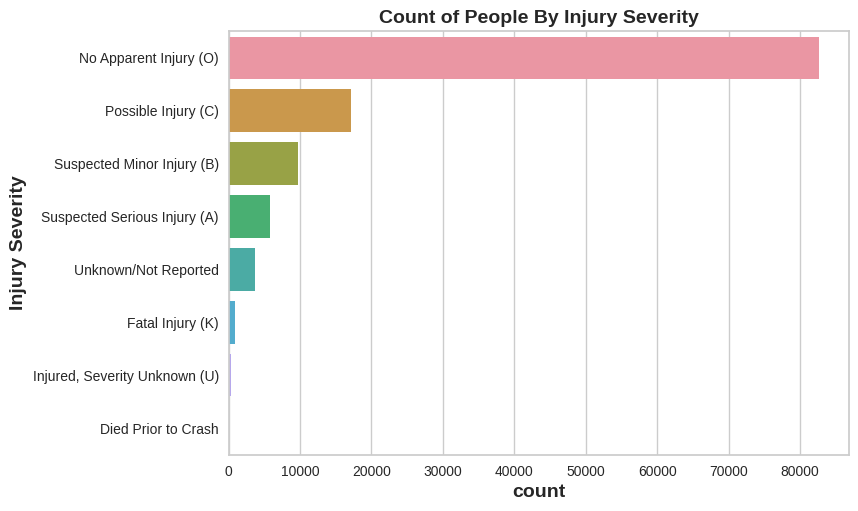

In [ ]:
injury_map = {'0' :'No Apparent Injury (O)',
              '1' : 'Possible Injury (C)',
              '2' : 'Suspected Minor Injury (B)',
              '3' : 'Suspected Serious Injury (A)',
              '4' : 'Fatal Injury (K)',
              '5' : 'Injured, Severity Unknown (U)',
              '6' : 'Died Prior to Crash',
              '9' : 'Unknown/Not Reported'
              }
count_injury = pd.DataFrame(persons['INJ_SEV'].value_counts()).reset_index().rename(columns = {'INJ_SEV' : 'count', 'index' : 'INJ_SEV'})
count_injury['INJ_SEV'] = count_injury['INJ_SEV'].map(injury_map)
sns.barplot(y='INJ_SEV', x='count', data=count_injury, orient = 'h')

plt.ylabel("Injury Severity",fontsize=14, weight='bold')
plt.xlabel("count",fontsize=14, weight='bold')
plt.title("Count of People By Injury Severity",fontsize=14, weight='bold')
plt.show()

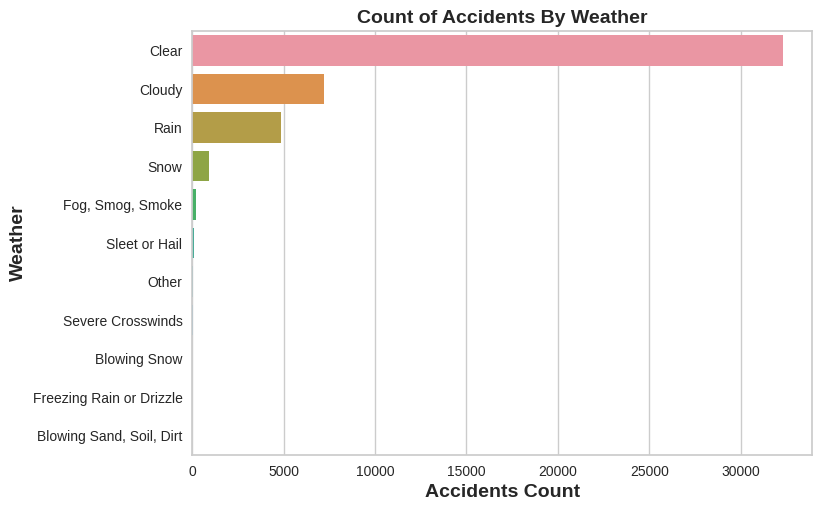

In [ ]:
weather_map = {'1' : 'Clear',
               '2' : 'Rain',
               '3' : 'Sleet or Hail',
               '4' : 'Snow',
               '5' : 'Fog, Smog, Smoke',
               '6' : 'Severe Crosswinds',
               '7' : 'Blowing Sand, Soil, Dirt',
               '8' : 'Other',
               '10' : 'Cloudy',
               '11' : 'Blowing Snow',
               '12' : 'Freezing Rain or Drizzle'
               }
accidents_by_weather = pd.DataFrame(accidents['WEATHER'].value_counts()).reset_index().rename(columns = {'WEATHER' : 'count', 'index':'WEATHER'})
accidents_by_weather['WEATHER'] = accidents_by_weather['WEATHER'].map(weather_map)
sns.barplot(y='WEATHER', x='count', data=accidents_by_weather, orient = 'h')

plt.xlabel("Accidents Count",fontsize=14, weight='bold')
plt.ylabel("Weather",fontsize=14, weight='bold')
plt.title("Count of Accidents By Weather",fontsize=14, weight='bold')
plt.show()

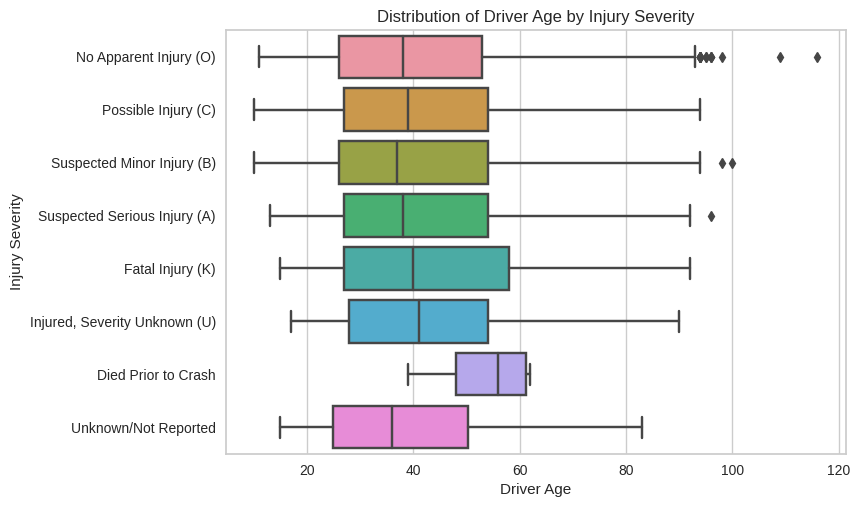

In [ ]:
# Create a box plot of driver age by accident type
injury_by_age = full_data[['AGE', 'INJ_SEV']]
injury_by_age = injury_by_age[injury_by_age['AGE'] != '998']
injury_by_age = injury_by_age[injury_by_age['AGE'] != '999']
injury_by_age['AGE'] = injury_by_age['AGE'].astype(int)
injury_by_age['INJ_SEV'] = injury_by_age['INJ_SEV'].astype('category').map(injury_map)
sns.boxplot(y='INJ_SEV', x='AGE', data=injury_by_age, orient = 'h')

# Set plot title and axis labels
plt.title('Distribution of Driver Age by Injury Severity')
plt.ylabel('Injury Severity')
plt.xlabel('Driver Age')

# Show the plot
plt.show()

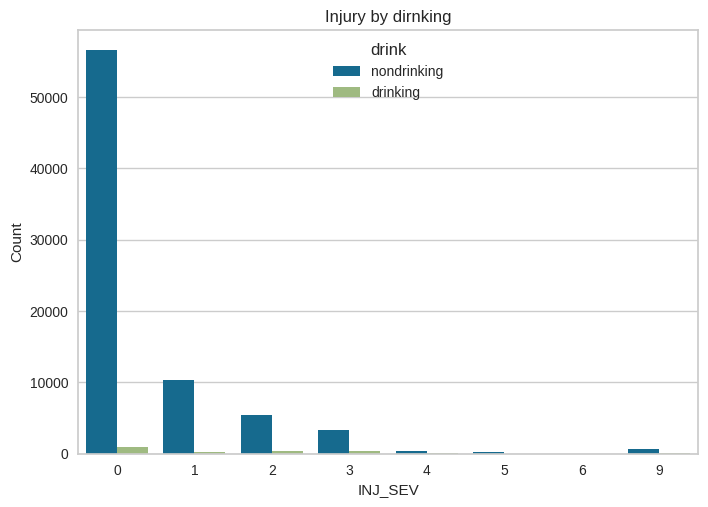

In [ ]:
injury_by_nondrinking = drivers[drivers['DRINKING']=='0']['INJ_SEV'].value_counts()
injury_by_drinking = drivers[drivers['DRINKING']=='1']['INJ_SEV'].value_counts()
injury_drinkers = pd.DataFrame({'nondrinking' : injury_by_nondrinking, 'drinking' : injury_by_drinking})
injury_drinkers = injury_drinkers.reset_index().rename(columns={"index": "INJ_SEV"}).melt(id_vars="INJ_SEV", var_name="drink", value_name="count")
sns.barplot(x="INJ_SEV", y="count", hue="drink", data=injury_drinkers)
plt.xlabel("INJ_SEV")
plt.ylabel("Count")
plt.title("Injury by dirnking")
plt.show()

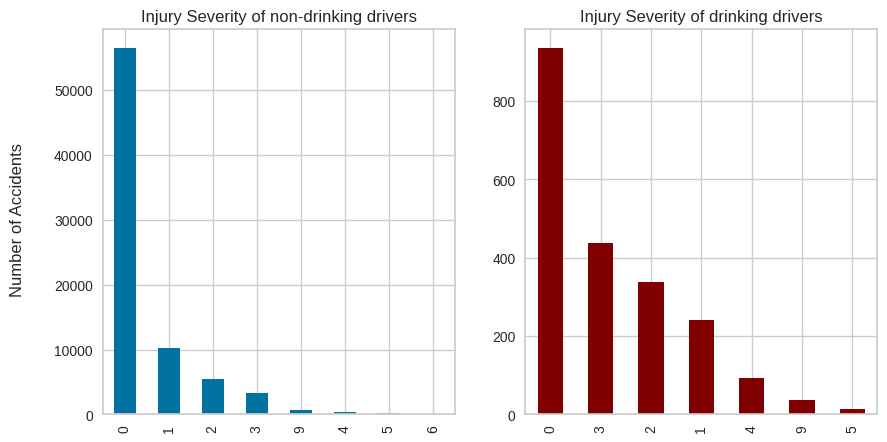

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Create a stacked bar chart
injury_by_nondrinking.plot(kind='bar', ax=axes[0], title = 'Injury Severity of non-drinking drivers')
injury_by_drinking.plot(kind='bar', ax=axes[1], title = 'Injury Severity of drinking drivers', color = 'maroon')
# Set plot title and axis labels
fig.text(0.04, 0.5, 'Number of Accidents', ha='center', va='center', rotation='vertical')
# Show the plot
plt.show()

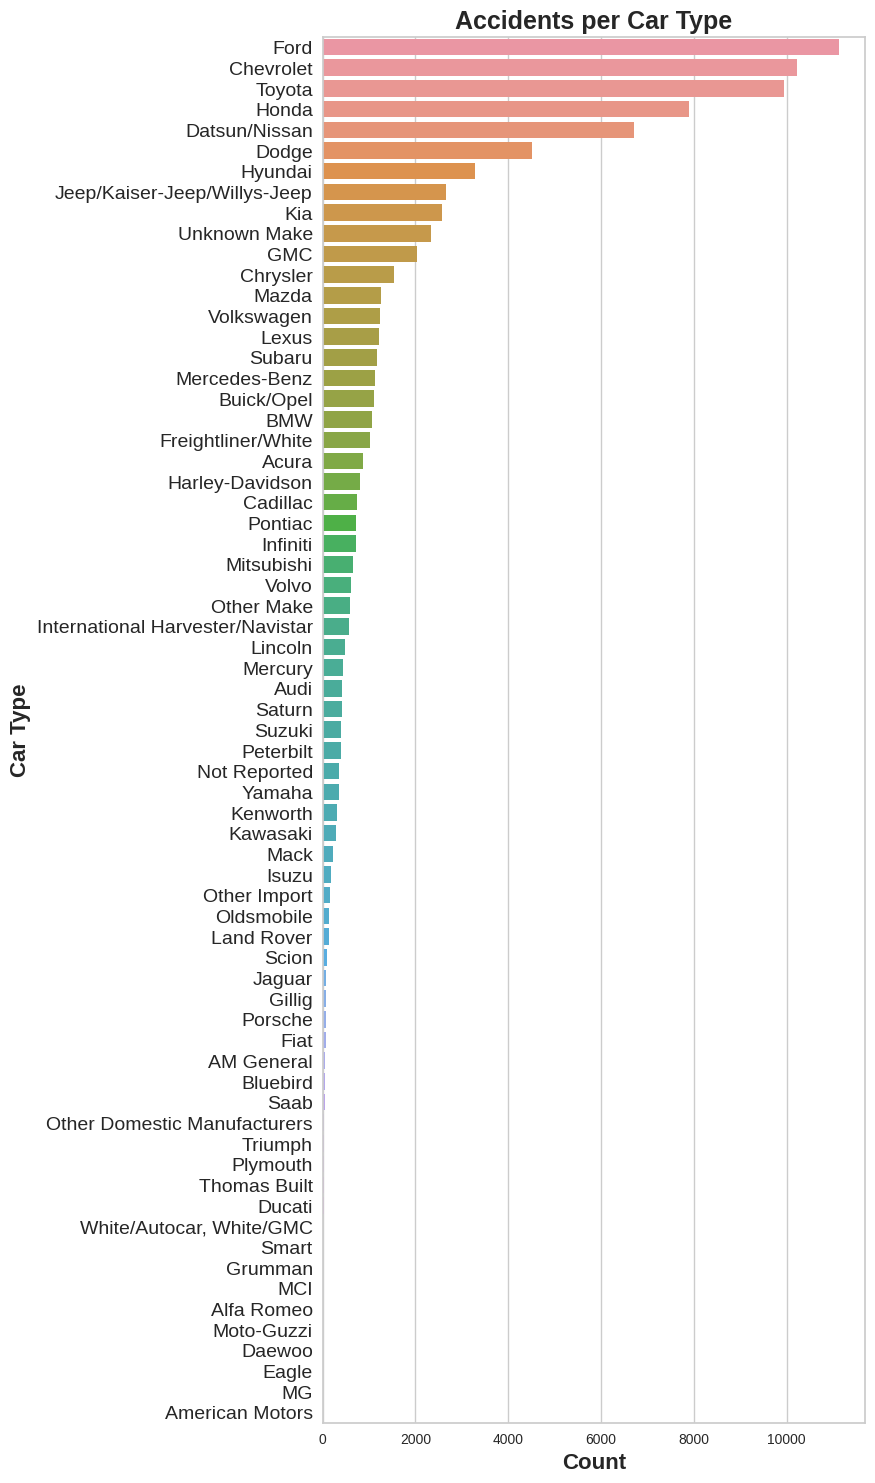

In [ ]:
make_map = {'1' : 'American Motors',
            '2' : 'Jeep/Kaiser-Jeep/Willys-Jeep',
            '3' : 'AM General',
            '6' : 'Chrysler',
            '7' : 'Dodge',
            '8' : 'Imperial',
            '9' : 'Plymouth',
            '10' : 'Eagle',
            '12' : 'Ford',
            '13' : 'Lincoln',
            '14' : 'Mercury',
            '18' : 'Buick/Opel',
            '19' : 'Cadillac',
            '20' : 'Chevrolet',
            '21' : 'Oldsmobile',
            '22' : 'Pontiac',
            '23' : 'GMC',
            '24' : 'Saturn',
            '25' : 'Grumman',
            '26' : 'Coda',
            '29' : 'Other Domestic Manufacturers',
            '30' : 'Volkswagen',
            '31' : 'Alfa Romeo',
            '32' : 'Audi',
            '33' : 'Austin/Austin Healey',
            '34' : 'BMW',
            '35' : 'Datsun/Nissan',
            '36' : 'Fiat',
            '37' : 'Honda',
            '38' : 'Isuzu',
            '39' : 'Jaguar',
            '40' : 'Lancia',
            '41' : 'Mazda',
            '42' : 'Mercedes-Benz',
            '43' : 'MG',
            '44' : 'Peugeot',
            '45' : 'Porsche',
            '46' : 'Renault',
            '47' : 'Saab',
            '48' : 'Subaru',
            '49' : 'Toyota',
            '50' : 'Triumph',
            '51' : 'Volvo',
            '52' : 'Mitsubishi',
            '53' : 'Suzuki',
            '54' : 'Acura',
            '55' : 'Hyundai',
            '56' : 'Merkur',
            '57' : 'Yugo',
            '58' : 'Infiniti',
            '59' : 'Lexus',
            '60' : 'Diahatsu',
            '61' : 'Sterling',
            '62' : 'Land Rover',
            '63' : 'Kia',
            '64' : 'Daewoo',
            '65' : 'Smart',
            '67' : 'Scion',
            '69' : 'Other Import',
            '70' : 'BSA',
            '71' : 'Ducati',
            '72' : 'Harley-Davidson',
            '73' : 'Kawasaki',
            '74' : 'Moto-Guzzi',
            '75' : 'Norton',
            '76' : 'Yamaha',
            '78' : 'Other Make Moped',
            '79' : 'Other Make Motored Cycle',
            '80' : 'Brockway',
            '81' : 'Diamond Reo/Reo',
            '82' : 'Freightliner/White',
            '83' : 'FWD',
            '84' : 'International Harvester/Navistar',
            '85' : 'Kenworth',
            '86' : 'Mack',
            '87' : 'Peterbilt',
            '88' : 'Iveco/Magirus',
            '89' : 'White/Autocar, White/GMC',
            '90' : 'Bluebird',
            '91' : 'Eagle Coach',
            '92' : 'Gillig',
            '93' : 'MCI',
            '94' :'Thomas Built',
            '97' : 'Not Reported',
            '98' : 'Other Make',
            '99' : 'Unknown Make'
            }
accidents_by_maker = pd.DataFrame(drivers['MAKE'].value_counts()).reset_index().rename(columns = {'MAKE' : 'count', 'index':'MAKE'})
accidents_by_maker['MAKE'] = accidents_by_maker['MAKE'].map(make_map)
plt.figure(figsize=[7,18])
sns.barplot(y='MAKE', x='count', data=accidents_by_maker, orient = 'h')

# Add labels and title
plt.ylabel('Car Type',fontsize=16, weight='bold')
plt.xlabel('Count',fontsize=16, weight='bold')
plt.yticks(fontsize=14)
plt.title('Accidents per Car Type',fontsize=18, weight='bold')

# Show the plot
plt.show()

---
## Imputation
Check if there are null values

In [ ]:
full_data.isnull().mean(axis = 0)

CASENUM      0.0
VE_FORMS     0.0
VEH_NO       0.0
PER_NO       0.0
REGION       0.0
            ... 
LGTCON_IM    0.0
WEATHR_IM    0.0
MAXSEV_IM    0.0
NO_INJ_IM    0.0
ALCHL_IM     0.0
Length: 150, dtype: float64

In [ ]:
print(sum(full_data.isnull().mean(axis = 0)))

0.0


Something is not right, we expected null values.

We will check distribution of values in each column:

In [ ]:
for col in full_data.columns:
  print(full_data[col].value_counts())

201800527327    15
201800441731    13
201800780312    10
201800959666    10
201800476475     9
                ..
201800663776     1
201800990953     1
201800663782     1
201800990941     1
201801402636     1
Name: CASENUM, Length: 48400, dtype: int64
2     58847
1     15272
3      8912
4      2108
5       475
6       126
7        70
8        40
10       20
9        18
15       15
13       13
Name: VE_FORMS, dtype: int64
1     48111
2     33255
3      3652
4       665
5       137
6        44
7        22
8        12
9         6
10        4
11        2
12        2
13        2
14        1
15        1
Name: VEH_NO, dtype: int64
1    85878
2       29
4        5
3        3
5        1
Name: PER_NO, dtype: int64
3    45608
2    14553
4    14437
1    11318
Name: REGION, dtype: int64
38    3786
67    3332
12    3249
17    3005
28    2998
33    2742
70    2729
59    2661
56    2564
48    2284
41    2269
25    2250
83    2206
72    2140
51    2102
46    2098
53    1893
54    1855
78    1769
80    

In [ ]:
for col in full_data.columns:
  display(pd.Series((full_data[col]).value_counts()/sum(full_data[col].value_counts()))*100)

201800527327    0.017459
201800441731    0.015131
201800780312    0.011639
201800959666    0.011639
201800476475    0.010475
                  ...   
201800663776    0.001164
201800990953    0.001164
201800663782    0.001164
201800990941    0.001164
201801402636    0.001164
Name: CASENUM, Length: 48400, dtype: float64

2     68.493645
1     17.775502
3     10.372922
4      2.453559
5      0.552866
6      0.146655
7      0.081475
8      0.046557
10     0.023279
9      0.020951
15     0.017459
13     0.015131
Name: VE_FORMS, dtype: float64

1     55.997719
2     38.706411
3      4.250663
4      0.774012
5      0.159458
6      0.051213
7      0.025606
8      0.013967
9      0.006984
10     0.004656
11     0.002328
12     0.002328
13     0.002328
14     0.001164
15     0.001164
Name: VEH_NO, dtype: float64

1    99.955771
2     0.033754
4     0.005820
3     0.003492
5     0.001164
Name: PER_NO, dtype: float64

3    53.084408
2    16.938638
4    16.803622
1    13.173332
Name: REGION, dtype: float64

38    4.406630
67    3.878207
12    3.781601
17    3.497602
28    3.489455
33    3.191489
70    3.176358
59    3.097211
56    2.984310
48    2.658411
41    2.640952
25    2.618837
83    2.567624
72    2.490805
51    2.446576
46    2.441920
53    2.203315
54    2.159086
78    2.058988
80    1.991480
35    1.964710
29    1.877415
31    1.865776
27    1.784301
40    1.756367
63    1.706318
58    1.678384
65    1.634154
32    1.465385
62    1.428139
68    1.335025
47    1.330369
39    1.315238
60    1.298943
61    1.251222
75    1.181386
49    1.167419
77    1.116207
20    1.081289
66    1.005633
34    0.966060
64    0.911355
44    0.885749
82    0.864798
55    0.855487
13    0.817077
76    0.815913
30    0.776340
37    0.768192
52    0.716979
10    0.679734
45    0.666930
24    0.608734
57    0.587783
50    0.484194
22    0.385260
14    0.356162
26    0.316588
81    0.287490
15    0.224638
Name: PSU, dtype: float64

573     3.110014
1053    3.063457
1919    2.526887
2810    2.113692
138     1.770334
          ...   
309     0.003492
149     0.002328
936     0.002328
2411    0.001164
147     0.001164
Name: PJ, Length: 380, dtype: float64

38     4.406630
67     3.878207
12     3.781601
17     3.497602
28     3.489455
         ...   
211    0.283998
205    0.267703
208    0.233949
15     0.224638
209    0.040737
Name: PSU_VAR, Length: 67, dtype: float64

1    80.093347
2    19.906653
Name: URBANICITY, dtype: float64

9     26.672564
10    19.178034
6     16.881605
8     11.732390
7      7.763397
5      5.560082
2      4.568416
3      4.383351
4      3.260161
Name: STRATUM, dtype: float64

0    100.0
Name: STR_VEH, dtype: float64

10    9.341683
11    8.834210
8     8.736440
5     8.718981
9     8.476884
12    8.339541
1     8.162624
6     8.152149
3     8.113739
7     7.939150
4     7.798315
2     7.386284
Name: MONTH, dtype: float64

17    9.079799
16    8.691047
15    8.411704
14    6.792681
18    6.635551
12    5.851064
13    5.814982
7     5.769589
8     5.297034
11    5.109642
9     4.334466
19    4.251827
10    4.128451
20    3.468504
21    3.036687
6     2.886540
22    2.324363
23    1.716793
5     1.381582
0     1.344336
1     1.040551
2     0.900880
4     0.736766
3     0.672750
99    0.322408
Name: HOUR, dtype: float64

0     6.296848
30    5.298198
45    3.749011
50    3.742027
20    3.644257
        ...   
31    1.056846
2     1.046371
21    1.020764
24    1.011453
99    0.322408
Name: MINUTE, Length: 61, dtype: float64

12    80.881326
8      2.567624
14     2.160250
11     1.915825
9      1.632990
1      1.447926
34     1.082453
42     1.000978
30     0.882257
33     0.872946
24     0.689045
59     0.465571
35     0.446948
25     0.436473
38     0.356162
18     0.343359
54     0.339867
53     0.280507
43     0.259556
32     0.216491
52     0.166442
31     0.166442
57     0.143163
15     0.140835
39     0.123376
5      0.108245
19     0.088458
40     0.074491
23     0.052377
44     0.045393
46     0.039574
2      0.039574
72     0.038410
93     0.036082
20     0.034918
51     0.034918
41     0.032590
50     0.032590
7      0.032590
91     0.031426
58     0.031426
45     0.030262
26     0.030262
17     0.029098
48     0.026770
16     0.025606
73     0.020951
21     0.017459
3      0.015131
99     0.013967
10     0.010475
6      0.005820
55     0.002328
Name: HARM_EV, dtype: float64

1     37.047814
6     25.359654
0     18.759020
7     11.304064
2      3.666372
8      1.677220
9      0.756553
11     0.649472
98     0.618046
99     0.090786
10     0.071000
Name: MAN_COLL, dtype: float64

0    99.334233
1     0.665767
Name: SCH_BUS, dtype: float64

12    12.959169
20    11.895340
49    11.562456
37     9.186880
35     7.814610
        ...    
74     0.004656
64     0.002328
10     0.002328
43     0.001164
1      0.001164
Name: MAKE, Length: 68, dtype: float64

4     35.220448
14    14.018343
34    11.035197
6      4.780250
15     4.071419
        ...    
96     0.002328
42     0.001164
91     0.001164
85     0.001164
13     0.001164
Name: BODY_TYP, Length: 65, dtype: float64

2017    8.182411
2016    7.864659
2015    7.728479
2014    7.088319
2013    5.435542
          ...   
1966    0.001164
1951    0.001164
1948    0.001164
1955    0.001164
1950    0.001164
Name: MOD_YEAR, Length: 68, dtype: float64

12481    3.001769
49040    2.660738
37032    2.615345
37031    2.355789
20481    2.334839
           ...   
47999    0.001164
47401    0.001164
82998    0.001164
53032    0.001164
7421     0.001164
Name: MAK_MOD, Length: 963, dtype: float64

0    96.574561
1     2.987802
9     0.337539
2     0.055869
5     0.036082
4     0.003492
6     0.003492
3     0.001164
Name: TOW_VEH, dtype: float64

0     95.763304
98     2.355789
99     0.666930
2      0.314260
5      0.265375
3      0.264212
1      0.264212
6      0.055869
7      0.037246
8      0.005820
4      0.003492
13     0.003492
Name: SPEC_USE, dtype: float64

0    98.719680
8     0.737930
9     0.288654
5     0.094278
2     0.079147
6     0.050049
4     0.025606
3     0.004656
Name: EMER_USE, dtype: float64

0    97.442851
1     1.281484
9     1.033568
2     0.242097
Name: ROLLOVER, dtype: float64

12    42.193538
6     20.989106
11     4.713907
1      4.328647
3      2.566460
82     2.516411
9      2.516411
62     2.462871
98     2.083430
7      1.784301
5      1.679547
0      1.670236
83     1.382746
10     1.354812
63     1.330369
61     1.283812
2      1.272173
81     1.215140
4      0.799618
8      0.793799
99     0.534243
14     0.232786
18     0.160622
13     0.123376
20     0.005820
19     0.005820
Name: IMPACT1, dtype: float64

0    99.799804
1     0.200196
Name: FIRE_EXP, dtype: float64

998    3.776945
22     2.517575
25     2.464035
19     2.437264
21     2.408166
         ...   
95     0.002328
98     0.002328
100    0.001164
109    0.001164
116    0.001164
Name: AGE, Length: 93, dtype: float64

1    55.294706
2    40.660645
8     2.268495
9     1.776153
Name: SEX, dtype: float64

1    100.0
Name: PER_TYP, dtype: float64

0    70.707435
1    12.738023
2     7.056893
3     4.716234
9     3.801387
4     0.740258
5     0.235113
6     0.004656
Name: INJ_SEV, dtype: float64

11    99.995344
13     0.004656
Name: SEAT_POS, dtype: float64

3     81.033800
99     6.430700
8      3.575585
98     2.799246
20     2.105545
19     1.368779
17     0.842684
2      0.719307
5      0.500489
1      0.435309
29     0.100098
97     0.051213
16     0.037246
Name: REST_USE, dtype: float64

0    99.766051
1     0.233949
Name: REST_MIS, dtype: float64

20    73.360026
98     7.763397
1      5.774245
9      5.322641
8      3.765306
99     3.242702
2      0.619209
3      0.129196
7      0.023279
Name: AIR_BAG, dtype: float64

0    89.238326
7     7.101122
8     2.927278
9     0.415522
1     0.239769
2     0.076819
3     0.001164
Name: EJECTION, dtype: float64

0    89.249965
8     4.411285
9     3.900321
1     2.438428
Name: DRINKING, dtype: float64

0    74.604265
8    23.515992
2     1.713301
9     0.166442
Name: ALC_STATUS, dtype: float64

0     74.604265
95    23.576517
1      0.853159
2      0.361981
98     0.204851
99     0.166442
11     0.124540
3      0.044229
10     0.041901
8      0.022115
Name: ATST_TYP, dtype: float64

996    74.604265
995    23.515992
997     1.081289
999     0.166442
0       0.128032
         ...    
13      0.001164
177     0.001164
84      0.001164
239     0.001164
188     0.001164
Name: ALC_RES, Length: 147, dtype: float64

0    86.319195
8     8.850505
9     4.014386
1     0.815913
Name: DRUGS, dtype: float64

0    84.730434
5     6.237488
3     5.132921
8     1.549188
4     1.402533
6     0.493505
1     0.263048
2     0.107081
9     0.083803
Name: HOSPITAL, dtype: float64

0    100.0
Name: P_SF1, dtype: float64

0    100.0
Name: P_SF2, dtype: float64

0    100.0
Name: P_SF3, dtype: float64

0    100.0
Name: LOCATION, dtype: float64

1    57.660971
2    42.339029
Name: SEX_IM, dtype: float64

0    73.586992
1    13.325807
2     7.217515
3     4.853578
4     0.748405
5     0.263048
6     0.004656
Name: INJSEV_IM, dtype: float64

0    96.718888
8     2.951720
1     0.250244
2     0.077983
3     0.001164
Name: EJECT_IM, dtype: float64

0    97.24382
1     2.75618
Name: PERALCH_IM, dtype: float64

11    99.995344
13     0.004656
Name: SEAT_IM, dtype: float64

22     2.672378
25     2.628148
19     2.590903
20     2.557149
21     2.553657
         ...   
95     0.002328
98     0.002328
100    0.001164
109    0.001164
116    0.001164
Name: AGE_IM, Length: 91, dtype: float64

10    7.602775
15    7.457284
14    7.342055
11    6.680944
8     6.497044
12    6.440011
13    6.166488
1     5.713720
22    5.082872
16    4.882676
2     4.673169
9     3.786256
6     3.462684
7     3.192653
21    3.146096
20    2.984310
17    2.320872
23    2.246380
18    2.145118
19    2.046185
25    1.967038
3     1.404861
24    1.376926
4     0.771684
5     0.609898
Name: PSUSTRAT, dtype: float64

171.09035147    1.060338
171.74742403    1.033568
170.64936251    1.000978
171.54669828    0.927650
68.140224518    0.817077
                  ...   
77.539562906    0.001164
245.04928238    0.001164
26.101426774    0.001164
66.795365036    0.001164
172.14565754    0.001164
Name: WEIGHT, Length: 2666, dtype: float64

1     71.562922
2     15.673448
99     5.349411
3      4.400810
4      1.905349
5      0.685553
6      0.186228
7      0.082639
8      0.036082
9      0.013967
10     0.011639
11     0.009311
14     0.006984
15     0.006984
22     0.004656
20     0.004656
19     0.004656
26     0.004656
12     0.004656
21     0.003492
28     0.003492
13     0.003492
17     0.003492
27     0.002328
37     0.002328
29     0.002328
35     0.002328
25     0.002328
38     0.002328
18     0.002328
23     0.001164
47     0.001164
56     0.001164
30     0.001164
31     0.001164
60     0.001164
34     0.001164
16     0.001164
32     0.001164
40     0.001164
62     0.001164
39     0.001164
43     0.001164
Name: NUMOCCS, dtype: float64

1    100.0
Name: UNITTYPE, dtype: float64

0    93.956888
1     6.036128
9     0.006984
Name: HIT_RUN, dtype: float64

481    6.273570
32     5.412263
399    5.064249
402    4.737185
999    4.394990
         ...   
902    0.001164
599    0.001164
598    0.001164
426    0.001164
908    0.001164
Name: MODEL, Length: 132, dtype: float64

888888888888    16.263560
999999999999     1.243075
000000000000     0.146655
3N1AB7AP3GY2     0.016295
3N1CN7AP7GL8     0.010475
                  ...    
1C6RR6LG1DS6     0.001164
2HGFA55548H7     0.001164
KM8J23A46HU3     0.001164
WVWAB7AJ1DW1     0.001164
1GNFC13077R2     0.001164
Name: VIN, Length: 60361, dtype: float64

0    96.921412
1     2.976163
3     0.057032
2     0.045393
Name: J_KNIFE, dtype: float64

0     93.614693
77     2.803901
57     1.862284
99     0.831044
88     0.551702
6      0.098934
13     0.040737
8      0.032590
48     0.030262
22     0.024442
17     0.010475
47     0.010475
42     0.008147
51     0.006984
37     0.005820
58     0.005820
28     0.005820
12     0.005820
18     0.005820
29     0.004656
4      0.004656
39     0.004656
40     0.003492
56     0.003492
1      0.002328
55     0.002328
20     0.002328
19     0.002328
23     0.002328
34     0.001164
31     0.001164
30     0.001164
33     0.001164
54     0.001164
27     0.001164
5      0.001164
21     0.001164
95     0.001164
49     0.001164
Name: MCARR_I1, dtype: float64

000000000    93.614693
777777777     2.814377
999999999     0.831044
888888888     0.551702
265752        0.012803
               ...    
372911        0.001164
457517        0.001164
2469042       0.001164
203287        0.001164
3062400SC     0.001164
Name: MCARR_I2, Length: 1686, dtype: float64

00000000000    93.614693
77777777777     2.803901
99999999999     0.831044
88888888888     0.551702
57265752        0.012803
                 ...    
06372911        0.001164
06457517        0.001164
572469042       0.001164
57203287        0.001164
373062400SC     0.001164
Name: MCARR_ID, Length: 1723, dtype: float64

0    93.255040
3     3.420783
2     1.839006
8     1.188370
9     0.283998
1     0.012803
Name: GVWR, dtype: float64

0     93.619349
6      2.138135
1      1.652777
99     0.736766
21     0.524931
2      0.428325
19     0.419014
4      0.278179
5      0.109409
7      0.053541
20     0.039574
Name: V_CONFIG, dtype: float64

0     93.626333
1      1.500303
98     1.248894
97     0.879929
99     0.708832
22     0.620373
3      0.392244
4      0.283998
96     0.263048
2      0.181573
7      0.098934
11     0.037246
5      0.036082
6      0.034918
12     0.029098
8      0.026770
10     0.018623
9      0.012803
Name: CARGO_BT, dtype: float64

1    99.956935
2     0.043065
Name: HAZ_INV, dtype: float64

0    99.956935
2     0.034918
1     0.005820
8     0.002328
Name: HAZ_PLAC, dtype: float64

0       99.956935
1203     0.012803
8888     0.011639
1993     0.003492
1075     0.002328
2187     0.002328
9999     0.001164
1073     0.001164
3082     0.001164
1805     0.001164
1791     0.001164
3295     0.001164
1862     0.001164
1863     0.001164
1987     0.001164
Name: HAZ_ID, dtype: float64

0     99.956935
88     0.013967
3      0.012803
2      0.008147
1      0.003492
8      0.003492
9      0.001164
Name: HAZ_CNO, dtype: float64

0    99.956935
1     0.031426
2     0.006984
8     0.004656
Name: HAZ_REL, dtype: float64

0     98.820941
99     0.357326
1      0.314260
98     0.260720
6      0.200196
5      0.017459
7      0.016295
8      0.006984
4      0.005820
Name: BUS_USE, dtype: float64

998    45.289585
0      14.862191
999     4.126123
10      3.636110
5       3.520881
         ...    
121     0.001164
103     0.001164
139     0.001164
105     0.001164
39      0.001164
Name: TRAV_SP, Length: 102, dtype: float64

0    97.442851
5     1.577122
1     0.586619
3     0.171097
6     0.093114
2     0.060524
9     0.036082
4     0.025606
7     0.006984
Name: ROLINLOC, dtype: float64

6    29.094697
2    25.948601
4    20.499092
8    18.657759
0     3.211276
9     2.588575
Name: DEFORMED, dtype: float64

5    52.782951
2    28.385865
8    10.406676
3     4.230877
7     4.151730
9     0.041901
Name: TOWED, dtype: float64

12    80.782392
8      2.596722
1      2.562968
14     2.159086
11     1.864612
9      1.634154
42     1.291960
30     0.987011
34     0.755389
24     0.592439
54     0.528423
33     0.413194
25     0.408539
59     0.330555
38     0.325900
35     0.293310
18     0.271195
43     0.246753
32     0.174589
53     0.172261
15     0.140835
31     0.140835
39     0.139671
19     0.132688
52     0.130360
57     0.121048
5      0.098934
2      0.082639
40     0.075655
23     0.047721
46     0.043065
51     0.032590
50     0.031426
44     0.030262
17     0.027934
45     0.027934
26     0.025606
93     0.025606
20     0.025606
41     0.024442
58     0.022115
7      0.020951
3      0.020951
48     0.020951
16     0.018623
99     0.018623
73     0.018623
21     0.016295
91     0.015131
72     0.013967
10     0.010475
6      0.004656
55     0.002328
Name: M_HARM, dtype: float64

0     98.825597
99     1.044043
42     0.067508
41     0.030262
39     0.018623
33     0.006984
35     0.005820
30     0.001164
Name: VEH_SC1, dtype: float64

0     98.954793
99     1.044043
35     0.001164
Name: VEH_SC2, dtype: float64

2    89.249965
9     8.311607
1     2.438428
Name: VEH_ALCH, dtype: float64

0    67.940779
1    14.188277
2     7.716840
3     5.384329
9     3.654733
4     0.857815
5     0.252572
6     0.004656
Name: MAX_VSEV, dtype: float64

0     67.945435
1     23.653336
2      3.660552
99     3.654733
3      0.700684
4      0.254900
5      0.082639
6      0.031426
7      0.011639
8      0.003492
9      0.001164
Name: NUM_INJV, dtype: float64

1    100.0
Name: DR_PRES, dtype: float64

99999    8.421016
35405    0.455096
30736    0.438801
43302    0.435309
35401    0.394571
           ...   
54956    0.001164
53024    0.001164
49103    0.001164
98373    0.001164
92619    0.001164
Name: DR_ZIP, Length: 9433, dtype: float64

0    92.318078
4     4.367056
9     1.575958
5     1.105731
3     0.614554
2     0.018623
Name: SPEEDREL, dtype: float64

0     89.036966
6      6.575027
10     1.052191
99     0.964896
58     0.572652
36     0.446948
60     0.230458
55     0.183901
16     0.167606
51     0.162950
8      0.139671
54     0.130360
24     0.083803
37     0.064016
9      0.044229
50     0.041901
56     0.026770
21     0.025606
23     0.024442
57     0.006984
18     0.006984
22     0.004656
91     0.003492
32     0.003492
Name: DR_SF1, dtype: float64

0     96.228875
36     2.111365
99     0.964896
10     0.229294
8      0.091950
6      0.090786
58     0.073327
37     0.044229
55     0.039574
60     0.038410
51     0.031426
56     0.010475
16     0.008147
54     0.006984
57     0.005820
21     0.004656
23     0.004656
24     0.004656
50     0.003492
9      0.002328
32     0.002328
59     0.001164
91     0.001164
Name: DR_SF2, dtype: float64

0     98.817450
99     0.964896
36     0.080311
60     0.027934
55     0.023279
58     0.020951
8      0.017459
37     0.010475
51     0.010475
10     0.009311
6      0.006984
57     0.002328
23     0.001164
54     0.001164
32     0.001164
18     0.001164
24     0.001164
56     0.001164
59     0.001164
Name: DR_SF3, dtype: float64

0     99.011826
99     0.964896
60     0.004656
36     0.003492
51     0.003492
58     0.003492
23     0.002328
37     0.002328
55     0.001164
24     0.001164
50     0.001164
Name: DR_SF4, dtype: float64

1    35.482332
3    20.756320
8    18.578612
2    12.857908
5     4.777923
0     2.704968
4     2.411658
6     2.330183
9     0.100098
Name: VTRAFWAY, dtype: float64

8    31.586666
2    30.175986
3    12.505238
4    10.140137
5     7.715676
0     2.704968
6     2.474510
1     1.733088
7     0.897388
9     0.066344
Name: VNUM_LAN, dtype: float64

45    18.188696
35    16.027282
98    14.915732
40     9.716467
55     9.357978
25     7.681922
65     5.897621
30     5.413427
70     3.547651
50     3.077424
0      2.714279
60     1.797104
20     0.521440
15     0.501653
75     0.256064
10     0.159458
80     0.114065
5      0.072164
99     0.039574
Name: VSPD_LIM, dtype: float64

1    79.804693
8     9.489501
2     3.333489
3     3.137949
0     2.704968
4     1.466549
9     0.062852
Name: VALIGN, dtype: float64

1    71.448857
8    14.038130
2     7.016155
0     2.704968
6     1.985660
5     1.502630
3     1.077797
4     0.162950
9     0.062852
Name: VPROFILE, dtype: float64

1     78.630290
2     14.680618
0      2.704968
98     1.317566
3      1.077797
4      1.051027
10     0.180409
6      0.145491
99     0.116393
11     0.062852
8      0.018623
5      0.009311
7      0.004656
Name: VSURCOND, dtype: float64

0     61.904651
3     23.010848
20     7.115089
97     2.807393
40     1.052191
2      1.026584
21     0.938126
98     0.620373
1      0.417850
4      0.283998
7      0.181573
8      0.157130
65     0.143163
50     0.122212
28     0.082639
99     0.069836
23     0.050049
9      0.013967
29     0.002328
Name: VTRAFCON, dtype: float64

0    61.904651
3    35.067973
8     2.839983
9     0.068672
1     0.067508
2     0.051213
Name: VTCONT_F, dtype: float64

1     49.075842
5     14.351227
11    10.055170
2      5.620606
14     5.412263
10     3.889846
15     3.804879
99     1.899530
4      1.595745
13     1.329205
6      0.912519
12     0.567997
16     0.389916
8      0.297965
98     0.251408
3      0.172261
9      0.161786
17     0.147819
7      0.064016
Name: P_CRASH1, dtype: float64

53    18.390055
50    10.424135
15     7.008008
62     5.320313
17     4.830299
66     4.391499
10     4.065599
52     3.726896
13     3.440570
60     3.417291
61     3.256669
11     3.030867
51     2.594395
80     2.340658
12     2.075283
6      1.993808
87     1.958890
67     1.662089
83     1.623679
16     1.580614
99     1.475860
65     1.232599
98     1.223288
20     1.170911
18     0.648308
19     0.598259
70     0.597095
72     0.571488
56     0.521440
64     0.517948
21     0.412030
90     0.345686
63     0.325900
78     0.300293
8      0.297965
54     0.288654
9      0.261884
5      0.259556
73     0.251408
88     0.249080
59     0.221146
14     0.175753
71     0.157130
1      0.153638
68     0.150147
3      0.105917
74     0.081475
81     0.066344
89     0.046557
4      0.041901
84     0.033754
55     0.025606
91     0.016295
82     0.016295
2      0.015131
92     0.009311
85     0.002328
Name: P_CRASH2, dtype: float64

99    69.637786
1     21.865543
16     4.109828
7      1.616695
6      1.451418
98     0.585456
9      0.274687
8      0.257228
15     0.077983
10     0.066344
11     0.024442
12     0.017459
5      0.015131
Name: P_CRASH3, dtype: float64

1    91.840868
9     4.692956
2     2.032218
4     0.621537
3     0.493505
5     0.299129
7     0.019787
Name: PCRASH4, dtype: float64

1    74.864984
4    10.867592
2     8.743424
3     2.395363
7     1.975185
9     0.730947
5     0.217654
6     0.204851
Name: PCRASH5, dtype: float64

20    9.768844
98    8.572326
21    8.403557
13    6.015178
68    3.738535
        ...   
63    0.002328
35    0.001164
34    0.001164
36    0.001164
37    0.001164
Name: ACC_TYPE, Length: 87, dtype: float64

777777777777    96.951674
888888888888     2.514084
999999999999     0.050049
000000000000     0.019787
1UYVS2539K26     0.002328
                  ...    
167000032420     0.001164
4KNTT1620FL1     0.001164
1R9ESB508TL0     0.001164
1E1H5Z2835RA     0.001164
1DW1A53236S6     0.001164
Name: TRLR1VIN, Length: 401, dtype: float64

777777777777    99.939476
888888888888     0.053541
1A9140219400     0.001164
3H3V281C1JT4     0.001164
1KKVD281XEL2     0.001164
999999999999     0.001164
1D9FS21291D0     0.001164
1GRAP561XEK2     0.001164
Name: TRLR2VIN, dtype: float64

777777777777    99.991853
888888888888     0.006984
999999999999     0.001164
Name: TRLR3VIN, dtype: float64

0    93.963872
1     6.036128
Name: HITRUN_IM, dtype: float64

4     37.122306
14    14.923879
34    11.639276
6      5.046790
15     4.346105
        ...    
94     0.002328
85     0.001164
42     0.001164
91     0.001164
13     0.001164
Name: BDYTYP_IM, Length: 61, dtype: float64

2017    8.316262
2016    8.028772
2015    7.936822
2014    7.286187
2013    5.699753
          ...   
1947    0.001164
1948    0.001164
1932    0.001164
1966    0.001164
1950    0.001164
Name: MDLYR_IM, Length: 66, dtype: float64

12    43.512268
6     21.103171
11     4.894315
1      4.524186
3      2.640952
82     2.617673
9      2.596722
62     2.539690
7      1.823874
5      1.733088
0      1.670236
83     1.432795
10     1.404861
63     1.365287
2      1.340845
61     1.329205
81     1.268681
4      0.826389
8      0.820569
14     0.253736
18     0.161786
13     0.128032
20     0.005820
19     0.005820
Name: IMPACT1_IM, dtype: float64

12    80.782392
8      2.597886
1      2.562968
14     2.159086
11     1.865776
9      1.636482
42     1.291960
30     0.987011
34     0.756553
24     0.592439
54     0.528423
33     0.413194
25     0.408539
59     0.330555
38     0.325900
35     0.293310
18     0.271195
43     0.247917
32     0.176917
53     0.172261
15     0.141999
31     0.141999
39     0.140835
19     0.132688
52     0.130360
57     0.121048
5      0.101262
2      0.082639
40     0.075655
23     0.048885
46     0.043065
51     0.032590
50     0.031426
44     0.030262
45     0.027934
17     0.027934
26     0.025606
20     0.025606
93     0.025606
41     0.024442
3      0.022115
58     0.022115
7      0.020951
48     0.020951
16     0.018623
73     0.018623
21     0.016295
91     0.015131
72     0.013967
10     0.010475
6      0.005820
55     0.002328
Name: VEVENT_IM, dtype: float64

1     50.295638
5     14.353555
11    10.178546
2      5.740491
14     5.476279
10     3.974813
15     3.966665
4      1.621351
13     1.342008
6      0.928814
12     0.570325
16     0.396899
8      0.323572
98     0.261884
9      0.178081
3      0.176917
17     0.150147
7      0.064016
Name: PCRASH1_IM, dtype: float64

0    70.606173
1    14.781880
2     7.892593
3     5.563574
4     0.870618
5     0.279343
6     0.005820
Name: MXVSEV_IM, dtype: float64

0    70.611993
1    24.551888
2     3.724568
3     0.720471
4     0.256064
5     0.086131
6     0.031426
7     0.012803
8     0.003492
9     0.001164
Name: NUMINJ_IM, dtype: float64

2    97.24382
1     2.75618
Name: V_ALCH_IM, dtype: float64

2     70.112668
1     15.479073
3     10.858280
4      2.578100
5      0.576144
6      0.172261
7      0.091950
8      0.053541
10     0.023279
9      0.020951
15     0.017459
13     0.015131
11     0.001164
Name: VE_TOTAL, dtype: float64

0     97.241492
1      2.383724
2      0.259556
3      0.081475
4      0.020951
5      0.005820
6      0.004656
7      0.001164
10     0.001164
Name: PVH_INVL, dtype: float64

0     95.437404
1      4.426416
2      0.108245
3      0.018623
4      0.005820
11     0.001164
7      0.001164
8      0.001164
Name: PEDS, dtype: float64

2     42.305275
3     21.559430
1     14.738815
4     10.362447
5      5.408771
6      2.845803
7      1.288468
8      0.668094
9      0.364309
10     0.182737
11     0.068672
12     0.064016
16     0.030262
13     0.027934
15     0.017459
21     0.017459
17     0.017459
14     0.015131
18     0.013967
20     0.003492
Name: PERMVIT, dtype: float64

0     95.047488
1      4.698776
2      0.189720
3      0.040737
4      0.012803
7      0.003492
8      0.002328
5      0.002328
6      0.001164
11     0.001164
Name: PERNOTMVIT, dtype: float64

0     51.314074
1     30.828949
2     10.717445
3      3.686159
4      1.369943
99     0.962568
5      0.549374
6      0.275851
7      0.161786
9      0.048885
8      0.044229
11     0.012803
12     0.012803
10     0.009311
17     0.005820
Name: NUM_INJ, dtype: float64

2018    100.0
Name: YEAR, dtype: float64

6    17.106243
5    15.625727
4    15.424368
3    15.332418
2    14.776060
7    12.179338
1     9.555845
Name: DAY_WEEK, dtype: float64

2    83.695703
9    12.545975
1     3.758322
Name: ALCOHOL, dtype: float64

0    51.311746
1    22.946832
2    13.308348
3     9.462731
4     1.613204
9     0.962568
5     0.392244
6     0.002328
Name: MAX_SEV, dtype: float64

0    65.507007
8    32.271055
1     2.203315
9     0.018623
Name: RELJCT1, dtype: float64

1     36.322687
2     24.768378
3     22.477769
8      7.060385
98     5.904604
20     1.064994
5      0.886913
4      0.628521
18     0.462079
7      0.214163
19     0.062852
6      0.059360
17     0.054705
99     0.029098
16     0.003492
Name: RELJCT2, dtype: float64

1     51.301271
2     25.278179
98    12.218911
3     10.413660
4      0.345686
6      0.178081
7      0.130360
5      0.068672
10     0.039574
99     0.025606
Name: TYP_INT, dtype: float64

0    98.084175
1     1.049863
4     0.682062
2     0.150147
3     0.033754
Name: WRK_ZONE, dtype: float64

1     88.443363
4      7.010336
7      1.742400
3      1.291960
5      0.442292
2      0.435309
11     0.212999
6      0.186228
8      0.119885
98     0.062852
12     0.030262
99     0.011639
10     0.010475
Name: REL_ROAD, dtype: float64

1    71.985428
3    15.140370
2     7.872806
5     2.210298
4     1.468877
8     0.609898
6     0.510964
9     0.167606
7     0.033754
Name: LGT_COND, dtype: float64

1     67.292472
10    15.280041
2      9.614042
98     5.421575
4      1.600400
5      0.324736
3      0.159458
99     0.131524
8      0.047721
6      0.046557
11     0.040737
12     0.023279
7      0.017459
Name: WEATHER1, dtype: float64

0     99.533265
2      0.228130
10     0.103590
4      0.045393
5      0.017459
6      0.015131
3      0.015131
12     0.012803
11     0.012803
8      0.004656
7      0.004656
98     0.004656
99     0.002328
Name: WEATHER2, dtype: float64

1     67.292472
10    15.012338
2      9.835188
98     5.421575
4      1.645794
5      0.324736
3      0.155966
99     0.131524
6      0.050049
8      0.047721
11     0.044229
12     0.023279
7      0.015131
Name: WEATHER, dtype: float64

0    89.249965
1    10.740723
9     0.009311
Name: INT_HWY, dtype: float64

0     96.333628
14     1.054518
28     0.804274
19     0.490014
16     0.251408
20     0.238605
3      0.202523
23     0.194376
27     0.098934
21     0.079147
15     0.060524
24     0.054705
5      0.041901
26     0.039574
13     0.019787
12     0.016295
25     0.015131
99     0.002328
17     0.002328
Name: CF1, dtype: float64

0     99.775362
27     0.074491
23     0.032590
15     0.023279
26     0.023279
28     0.022115
19     0.019787
20     0.008147
14     0.006984
16     0.004656
21     0.003492
99     0.002328
3      0.002328
24     0.001164
Name: CF2, dtype: float64

0     99.987197
28     0.006984
99     0.002328
15     0.001164
14     0.001164
23     0.001164
Name: CF3, dtype: float64

6    17.106243
5    15.625727
4    15.424368
3    15.332418
2    14.776060
7    12.179338
1     9.555845
Name: WKDY_IM, dtype: float64

17    9.092602
16    8.716653
15    8.427999
14    6.817124
18    6.659993
12    5.861539
13    5.825457
7     5.795195
8     5.314493
11    5.123609
9     4.344942
19    4.263467
10    4.147074
20    3.489455
21    3.049490
6     2.892360
22    2.336003
23    1.727268
5     1.390893
0     1.353648
1     1.044043
2     0.905536
4     0.743750
3     0.677406
Name: HOUR_IM, dtype: float64

0     6.296848
30    5.305182
45    3.757158
50    3.751339
20    3.648913
40    3.594208
15    3.575585
10    3.140277
25    2.752689
5     2.746869
55    2.689837
35    2.637460
52    1.330369
48    1.317566
28    1.281484
54    1.279156
27    1.268681
42    1.257042
18    1.255878
6     1.241911
38    1.238419
22    1.237255
12    1.237255
58    1.225616
3     1.216304
29    1.208157
8     1.203501
43    1.201173
37    1.195354
53    1.191862
39    1.190698
47    1.182550
7     1.179059
1     1.179059
56    1.177895
23    1.173239
44    1.170911
46    1.165091
36    1.163928
49    1.161600
14    1.154616
32    1.144141
57    1.144141
13    1.142977
16    1.132502
33    1.131338
17    1.119698
4     1.118534
41    1.115043
26    1.111551
19    1.095256
51    1.095256
9     1.090600
34    1.085944
11    1.071977
59    1.066158
31    1.060338
2     1.047535
21    1.030076
24    1.014945
Name: MINUTE_IM, dtype: float64

12    80.881326
8      2.567624
14     2.160250
11     1.920480
9      1.632990
1      1.449090
34     1.083617
42     1.003306
30     0.882257
33     0.874110
24     0.689045
59     0.465571
35     0.446948
25     0.436473
38     0.356162
18     0.343359
54     0.339867
53     0.281670
43     0.259556
32     0.216491
52     0.166442
31     0.166442
57     0.143163
15     0.140835
39     0.124540
5      0.109409
19     0.088458
40     0.074491
23     0.052377
44     0.045393
2      0.039574
46     0.039574
72     0.038410
93     0.036082
20     0.034918
51     0.034918
41     0.032590
7      0.032590
50     0.032590
91     0.031426
58     0.031426
45     0.030262
26     0.030262
17     0.029098
48     0.026770
16     0.025606
73     0.020951
21     0.017459
3      0.015131
10     0.010475
6      0.005820
55     0.002328
Name: EVENT1_IM, dtype: float64

1     37.275944
6     25.668094
0     18.775315
7     11.384375
2      3.710601
8      1.695842
9      0.769356
11     0.649472
10     0.071000
Name: MANCOL_IM, dtype: float64

0    96.301038
1     3.698962
Name: RELJCT1_IM, dtype: float64

1     40.158993
2     25.186228
3     23.500861
8      7.406071
20     1.201173
5      0.954421
4      0.651799
18     0.505145
7      0.238605
19     0.069836
6      0.062852
17     0.060524
16     0.003492
Name: RELJCT2_IM, dtype: float64

1    72.388147
3    15.261418
2     8.070674
5     2.244052
4     1.487499
6     0.514456
7     0.033754
Name: LGTCON_IM, dtype: float64

1     71.592020
10    15.676940
2     10.265841
4      1.754039
5      0.346850
3      0.162950
6      0.057032
8      0.052377
11     0.052377
12     0.023279
7      0.016295
Name: WEATHR_IM, dtype: float64

0    51.113879
1    23.517156
2    13.528330
3     9.778155
4     1.634154
5     0.425997
6     0.002328
Name: MAXSEV_IM, dtype: float64

0     51.116207
1     31.440011
2     11.121328
3      3.767634
4      1.400205
5      0.571488
6      0.282834
7      0.164114
8      0.046557
9      0.043065
10     0.015131
11     0.012803
12     0.012803
17     0.005820
Name: NO_INJ_IM, dtype: float64

2    95.670189
1     4.329811
Name: ALCHL_IM, dtype: float64

We can see that most of the null values are imputated as 8,9,98,99,998,999, which are not correct, we would like to change it to np.nan and after that do KNN Imputation.

Moreover, we can see some columns that are not relevant to our analysis.

We will summarize it in a DataFrame:

In [ ]:
pd.set_option('display.max_rows', 150)
Imputation_reasons_df = pd.DataFrame(full_data.columns, columns=['Column Name'])
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'CASENUM',['Can Remove?', 'Reason', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [True, 'Used to be the key but after merge it is irrelevent', False, np.nan, np.nan]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'VE_FORMS',['Can Remove?','Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'VEH_NO',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Unique number given by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'PER_NO',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Unique number given by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'REGION',['Can Remove?', 'Need Imputation?']] = [False, False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'PSU',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Related to sampling method of the data', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'PJ',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Related to sampling method of the data', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'PSU_VAR',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Related to sampling method of the data', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'URBANICITY',['Can Remove?', 'Need Imputation?']] = [False, False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'STRATUM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'STR_VEH',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'The column contains one value', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'MONTH',['Can Remove?', 'Need Imputation?']] = [False, False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'HOUR',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {99}, '0.322408%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'MINUTE',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'The reporter round up the number', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'HARM_EV',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'MAN_COLL',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'SCH_BUS',['Can Remove?', 'Need Imputation?']] = [False, False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'MAKE',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [ False, True, {99}, '2.729410%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'BODY_TYP',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {98,99}, '1.70399%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'MOD_YEAR',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {9998,9999}, '4.012058%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'MAK_MOD',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {99998,99999}, '4.012058%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'TOW_VEH',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {9}, '0.337539%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'SPEC_USE',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {98,99}, '3.022719%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'EMER_USE',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {8,9}, '1.026584%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'ROLLOVER',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'IMPACT1',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'FIRE_EXP',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'AGE',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {998,999}, '5.139904%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'SEX',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {8,9}, '4.044648%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'PER_TYP',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'The column contains one value', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'INJ_SEV',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {9},'3.801387%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'SEAT_POS',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'The column contains one value', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'REST_USE',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {98,99}, '9.229946%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'REST_MIS',['Can Remove?', 'Need Imputation?']] = [False, False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'AIR_BAG',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'EJECTION',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'DRINKING',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {8,9}, '8.311606%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'ALC_STATUS',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent, the same as ALCOHOL', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'ATST_TYP',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent, the same as ALCOHOL', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'ALC_RES',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent, the same as ALCOHOL', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'DRUGS',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {8,9}, '12.864891%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'HOSPITAL',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'P_SF1',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'The column contains one value', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'P_SF2',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'The column contains one value', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'P_SF3',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'The column contains one value', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'LOCATION',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'The column contains one value', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'SEX_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'INJSEV_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'EJECT_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'PERALCH_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'SEAT_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'AGE_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'PSUSTRAT',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Related to sampling method of the data', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'WEIGHT',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Related to sampling method of the data', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'NUMOCCS',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'UNITTYPE',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'The column contains one value', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'HIT_RUN',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent to our analysis', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'MODEL',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {999}, '4.394990%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'VIN',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent to our analysis', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'J_KNIFE',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent to our analysis', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'MCARR_I1',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent to our analysis', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'MCARR_I2',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent to our analysis', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'MCARR_ID',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent to our analysis', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'GVWR',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent to our analysis', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'V_CONFIG',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent to our analysis', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'CARGO_BT',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent to our analysis', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'HAZ_INV',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent, the same as HAZ_REL', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'HAZ_PLAC',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent, the same as HAZ_REL', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'HAZ_ID',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent, the same as HAZ_REL', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'HAZ_CNO',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent, the same as HAZ_REL', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'HAZ_REL',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {8}, '0.004656%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'BUS_USE',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent, the same as SCH_BUS', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'TRAV_SP',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {997,998,999}, '49.416872%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'ROLINLOC',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'DEFORMED',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'TOWED',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'M_HARM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent, the same as HARM_EV', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'VEH_SC1',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'VEH_SC2',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'VEH_ALCH',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent, the same as ALCOHOL', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'MAX_VSEV',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent, we have the driver inj_sev already', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'NUM_INJV',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent, the same as NUM_INJ', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'DR_PRES',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'The column contains one value', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'DR_ZIP',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {99999}, '8.421016%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'SPEEDREL',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'DR_SF1',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'DR_SF2',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'DR_SF3',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'DR_SF4',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Unique number given by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'VTRAFWAY',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {8,9}, '5%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'VNUM_LAN',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {8,9}, '5%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'VSPD_LIM',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {98,99}, '5%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'VALIGN',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {8,9}, '5%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'VPROFILE',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {8,9}, '5%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'VSURCOND',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {98,99}, '5%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'VTRAFCON',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'VTCONT_F',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'P_CRASH1',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'P_CRASH2',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'P_CRASH3',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'PCRASH4',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'PCRASH5',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'ACC_TYPE',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'TRLR1VIN',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'TRLR2VIN',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'TRLR3VIN',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'HITRUN_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'BDYTYP_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'MDLYR_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'IMPACT1_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'VEVENT_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'PCRASH1_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'MXVSEV_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'NUMINJ_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'V_ALCH_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'VE_TOTAL',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent, the same as VE_FORMS', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'PVH_INVL',['Can Remove?', 'Need Imputation?']] = [False, False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'PEDS',['Can Remove?', 'Need Imputation?']] = [True, False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'PERMVIT',['Can Remove?', 'Need Imputation?']] = [False, False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'PERNOTMVIT',['Can Remove?', 'Need Imputation?']] = [True, False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'NUM_INJ',['Can Remove?', 'Need Imputation?']] = [True, False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'YEAR',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'The column contains one value', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'DAY_WEEK',['Can Remove?', 'Need Imputation?']] = [False, False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'ALCOHOL',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {9}, '5%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'MAX_SEV',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'RELJCT1',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'RELJCT2',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {98,99}, '5%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'TYP_INT',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {98,99}, '5%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'WRK_ZONE',['Can Remove?', 'Need Imputation?']] = [False, False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'REL_ROAD',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'LGT_COND',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {8,9}, '5%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'WEATHER1',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent, the same as WEATHER', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'WEATHER2',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent, the same as WEATHER', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'WEATHER',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {98,99}, '5%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'INT_HWY',['Can Remove?', 'Need Imputation?', 'Imputation value',	'Impuation values (%)']] = [False, True, {9}, '5%']
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'CF1',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'CF2',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'CF3',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Irrelevent', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'WKDY_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'HOUR_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'MINUTE_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'EVENT1_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'MANCOL_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'RELJCT1_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'RELJCT2_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'LGTCON_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'WEATHR_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'MAXSEV_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'NO_INJ_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df.loc[Imputation_reasons_df['Column Name'] == 'ALCHL_IM',['Can Remove?', 'Reason', 'Need Imputation?']] = [True, 'Imputation by the reporter', False]
Imputation_reasons_df

,Column Name,Can Remove?,Reason,Need Imputation?,Imputation value,Impuation values (%)
0,CASENUM,True,Used to be the key but after merge it is irrel...,False,NaN,NaN
1,VE_FORMS,True,Irrelevent,False,NaN,NaN
2,VEH_NO,True,Unique number given by the reporter,False,NaN,NaN
3,PER_NO,True,Unique number given by the reporter,False,NaN,NaN
4,REGION,False,NaN,False,NaN,NaN
5,PSU,True,Related to sampling method of the data,False,NaN,NaN
6,PJ,True,Related to sampling method of the data,False,NaN,NaN
7,PSU_VAR,True,Related to sampling method of the data,False,NaN,NaN
8,URBANICITY,False,NaN,False,NaN,NaN
9,STRATUM,True,Irrelevent,False,NaN,NaN


Removing unrelevent columns:

In [ ]:
full_data.drop(Imputation_reasons_df[Imputation_reasons_df['Can Remove?']]['Column Name'].values,axis = 1,inplace=True)

Replacing imputation values to NaN:

In [ ]:
for col, impute_values in zip(
        Imputation_reasons_df[Imputation_reasons_df['Need Imputation?']]['Column Name'].values,
        Imputation_reasons_df[Imputation_reasons_df['Need Imputation?']]['Imputation value'].values):
    full_data[col] = full_data[col].astype(int)
    full_data.loc[full_data[col].isin(impute_values), col] = np.nan

We will do KNN imputation to the data:

In [ ]:
knn_imputer = im(n_neighbors = 1 , weights = 'uniform', metric= 'nan_euclidean')
full_knn = pd.DataFrame(knn_imputer.fit_transform(full_data), columns = full_data.columns)
full_knn

,REGION,URBANICITY,MONTH,HOUR,SCH_BUS,MAKE,BODY_TYP,MOD_YEAR,MAK_MOD,TOW_VEH,...,PVH_INVL,PERMVIT,DAY_WEEK,ALCOHOL,RELJCT2,TYP_INT,WRK_ZONE,LGT_COND,WEATHER,INT_HWY
0,4.0,1.0,1.0,8.0,0.0,12.0,4.0,2015.0,12023.0,0.0,...,0.0,4.0,4.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0
1,4.0,1.0,1.0,8.0,0.0,37.0,14.0,2010.0,37402.0,0.0,...,0.0,4.0,4.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0
2,4.0,1.0,1.0,8.0,0.0,34.0,14.0,2007.0,34402.0,0.0,...,0.0,4.0,4.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0
3,4.0,1.0,1.0,8.0,0.0,69.0,9.0,2007.0,69054.0,0.0,...,0.0,4.0,4.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0
4,4.0,1.0,1.0,14.0,0.0,49.0,9.0,2007.0,49046.0,0.0,...,0.0,3.0,3.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85911,4.0,1.0,12.0,17.0,0.0,19.0,9.0,2008.0,19018.0,0.0,...,0.0,2.0,7.0,2.0,8.0,1.0,0.0,3.0,2.0,0.0
85912,4.0,1.0,12.0,17.0,0.0,30.0,9.0,2014.0,30046.0,0.0,...,0.0,2.0,7.0,2.0,8.0,1.0,0.0,3.0,2.0,0.0
85913,4.0,1.0,12.0,17.0,0.0,42.0,9.0,1996.0,42048.0,0.0,...,0.0,2.0,6.0,2.0,2.0,2.0,0.0,3.0,1.0,0.0
85914,4.0,1.0,12.0,17.0,0.0,7.0,20.0,2017.0,7442.0,0.0,...,0.0,2.0,6.0,2.0,2.0,2.0,0.0,3.0,1.0,0.0


Save the data after KNN imputation

In [ ]:
full_knn.to_csv('full_knn.csv')

In [ ]:
for col in full_knn.columns:
  display(pd.Series((full_data[col]).value_counts()))

3    45608
2    14553
4    14437
1    11318
Name: REGION, dtype: int64

1    68813
2    17103
Name: URBANICITY, dtype: int64

10    8026
11    7590
8     7506
5     7491
9     7283
12    7165
1     7013
6     7004
3     6971
7     6821
4     6700
2     6346
Name: MONTH, dtype: int64

17.0    7801
16.0    7467
15.0    7227
14.0    5836
18.0    5701
12.0    5027
13.0    4996
7.0     4957
8.0     4551
11.0    4390
9.0     3724
19.0    3653
10.0    3547
20.0    2980
21.0    2609
6.0     2480
22.0    1997
23.0    1475
5.0     1187
0.0     1155
1.0      894
2.0      774
4.0      633
3.0      578
Name: HOUR, dtype: int64

0    85344
1      572
Name: SCH_BUS, dtype: int64

12.0    11134
20.0    10220
49.0     9934
37.0     7893
35.0     6714
7.0      4507
55.0     3287
2.0      2659
63.0     2566
23.0     2037
6.0      1538
41.0     1268
30.0     1247
59.0     1222
48.0     1171
42.0     1128
18.0     1107
34.0     1064
82.0     1031
54.0      881
72.0      806
19.0      753
22.0      730
58.0      718
52.0      648
51.0      608
98.0      598
84.0      581
13.0      478
14.0      447
32.0      426
24.0      409
53.0      408
87.0      406
97.0      355
76.0      349
85.0      311
73.0      284
86.0      231
38.0      185
69.0      162
21.0      137
62.0      131
67.0      104
39.0       85
92.0       85
45.0       72
36.0       65
3.0        52
90.0       51
47.0       49
29.0       38
50.0       33
9.0        30
94.0       26
71.0       23
77.0       19
89.0       18
65.0       17
25.0       10
93.0       10
31.0        5
74.0        4
64.0        2
10.0        2
43.0        1
1.0         1
Name: MAKE, dtype: int64

4.0     30260
14.0    12044
34.0     9481
6.0      4107
15.0     3498
2.0      2768
49.0     2763
20.0     2714
9.0      2357
5.0      2176
80.0     2145
66.0     2022
21.0      911
8.0       774
3.0       691
61.0      686
19.0      658
1.0       570
63.0      535
39.0      506
67.0      373
62.0      330
50.0      250
16.0      205
29.0      197
64.0      177
84.0      170
52.0      162
79.0      143
78.0      111
89.0       78
48.0       76
40.0       75
81.0       75
55.0       56
65.0       34
60.0       33
92.0       31
83.0       31
59.0       24
90.0       20
58.0       18
17.0       17
10.0       15
51.0       14
22.0       12
82.0       11
7.0         6
72.0        6
93.0        5
88.0        4
97.0        4
28.0        4
71.0        3
12.0        3
45.0        3
95.0        2
94.0        2
96.0        2
42.0        1
91.0        1
85.0        1
13.0        1
Name: BODY_TYP, dtype: int64

2017.0    7030
2016.0    6757
2015.0    6640
2014.0    6090
2013.0    4670
2018.0    4188
2012.0    4110
2007.0    4066
2006.0    3951
2008.0    3803
2005.0    3632
2011.0    3444
2004.0    3216
2010.0    3069
2003.0    2785
2009.0    2645
2002.0    2376
2001.0    2075
2000.0    1766
1999.0    1363
1998.0    1071
1997.0     847
1996.0     544
1995.0     466
1994.0     343
2019.0     337
1993.0     222
1992.0     185
1991.0     152
1989.0     105
1990.0     102
1988.0      78
1985.0      51
1986.0      45
1987.0      35
1984.0      31
1983.0      20
1982.0      19
1979.0      18
1980.0      14
1981.0      11
1977.0      10
1972.0      10
1978.0       9
1976.0       8
1974.0       8
1971.0       6
1967.0       5
1965.0       5
1973.0       5
1969.0       5
1970.0       5
1975.0       4
1968.0       3
1963.0       2
1964.0       2
1932.0       1
1956.0       1
1947.0       1
1933.0       1
1931.0       1
1966.0       1
1951.0       1
1948.0       1
1955.0       1
1950.0       1
Name: MOD_

12481.0    2579
49040.0    2286
37032.0    2247
37031.0    2024
20481.0    2006
           ... 
47401.0       1
98902.0       1
82998.0       1
53032.0       1
7421.0        1
Name: MAK_MOD, Length: 961, dtype: int64

0.0    82973
1.0     2567
2.0       48
5.0       31
4.0        3
6.0        3
3.0        1
Name: TOW_VEH, dtype: int64

0.0     82276
2.0       270
5.0       228
3.0       227
1.0       227
6.0        48
7.0        32
8.0         5
4.0         3
13.0        3
Name: SPEC_USE, dtype: int64

0.0    84816
5.0       81
2.0       68
6.0       43
4.0       22
3.0        4
Name: EMER_USE, dtype: int64

12.0    36251
6.0     18033
11.0     4050
1.0      3719
3.0      2205
82.0     2162
9.0      2162
62.0     2116
7.0      1533
5.0      1443
0.0      1435
83.0     1188
10.0     1164
63.0     1143
61.0     1103
2.0      1093
81.0     1044
4.0       687
8.0       682
14.0      200
18.0      138
13.0      106
20.0        5
19.0        5
Name: IMPACT1, dtype: int64

22.0     2163
25.0     2117
19.0     2094
21.0     2069
20.0     2069
28.0     2044
23.0     2041
26.0     2038
27.0     2022
24.0     1977
18.0     1970
30.0     1812
29.0     1779
31.0     1712
32.0     1653
33.0     1604
36.0     1574
35.0     1573
38.0     1533
37.0     1528
17.0     1524
34.0     1520
41.0     1450
47.0     1423
39.0     1396
46.0     1396
40.0     1376
48.0     1323
49.0     1311
42.0     1303
44.0     1286
43.0     1278
53.0     1272
50.0     1242
51.0     1235
45.0     1225
52.0     1218
55.0     1209
54.0     1208
57.0     1176
56.0     1155
58.0     1135
59.0     1073
60.0     1062
61.0     1059
62.0      944
63.0      943
16.0      879
64.0      782
65.0      735
66.0      716
67.0      663
68.0      634
71.0      601
70.0      571
69.0      567
72.0      442
73.0      433
75.0      384
74.0      350
76.0      304
77.0      291
78.0      252
79.0      233
80.0      217
81.0      196
82.0      168
83.0      143
84.0      125
85.0      109
86.0       97
15.0  

1.0    47507
2.0    34934
Name: SEX, dtype: int64

0.0    60749
1.0    10944
2.0     6063
3.0     4052
4.0      636
5.0      202
6.0        4
Name: INJ_SEV, dtype: int64

3.0     69621
8.0      3072
20.0     1809
19.0     1176
17.0      724
2.0       618
5.0       430
1.0       374
29.0       86
97.0       44
16.0       32
Name: REST_USE, dtype: int64

0    85715
1      201
Name: REST_MIS, dtype: int64

0.0    76680
1.0     2095
Name: DRINKING, dtype: int64

0.0    74162
1.0      701
Name: DRUGS, dtype: int64

481.0    5390
32.0     4650
399.0    4351
402.0    4070
401.0    3416
37.0     2867
40.0     2849
881.0    2467
31.0     2446
47.0     2314
403.0    2007
421.0    1971
482.0    1787
499.0    1754
404.0    1651
43.0     1642
35.0     1637
51.0     1568
34.0     1321
706.0    1270
422.0    1207
472.0    1180
441.0    1169
23.0     1164
442.0    1110
2.0      1077
33.0     1068
25.0      946
46.0      898
24.0      887
50.0      853
884.0     844
39.0      808
471.0     806
461.0     740
38.0      735
3.0       709
22.0      675
17.0      580
18.0      557
42.0      519
36.0      511
709.0     492
20.0      467
705.0     430
405.0     404
880.0     373
16.0      361
997.0     355
9.0       352
49.0      352
28.0      346
45.0      342
1.0       341
423.0     332
473.0     331
48.0      327
27.0      296
41.0      277
54.0      255
52.0      243
7.0       237
29.0      234
26.0      230
870.0     227
407.0     223
443.0     222
21.0      208
44.0      192
431.0     174
703.0     170
6.0   

0.0    85879
1.0       27
2.0        6
Name: HAZ_REL, dtype: int64

0.0      12769
10.0      3124
5.0       3025
35.0      2811
45.0      2510
15.0      2427
30.0      2382
25.0      2319
20.0      2190
40.0      1976
55.0      1452
50.0      1119
65.0      1003
60.0       853
70.0       663
2.0        324
3.0        322
8.0        200
75.0       193
1.0        155
13.0       126
80.0       114
23.0       103
33.0        92
18.0        86
38.0        77
28.0        72
4.0         72
43.0        69
68.0        63
7.0         58
53.0        55
63.0        52
48.0        47
58.0        46
90.0        40
6.0         33
99.0        29
12.0        26
85.0        23
47.0        22
100.0       21
37.0        21
62.0        16
73.0        16
67.0        15
32.0        15
57.0        13
64.0        13
56.0        12
17.0        12
72.0        11
78.0        10
42.0         9
66.0         9
27.0         9
22.0         7
9.0          7
95.0         7
36.0         6
26.0         6
61.0         5
44.0         5
46.0         5
11.0         5
52.0         5
98.0      

35405.0    391
30736.0    377
43302.0    374
35401.0    339
44601.0    306
          ... 
62864.0      1
57038.0      1
28327.0      1
61360.0      1
92619.0      1
Name: DR_ZIP, Length: 9432, dtype: int64

1.0    30485
3.0    17833
2.0    11047
5.0     4105
0.0     2324
4.0     2072
6.0     2002
Name: VTRAFWAY, dtype: int64

2.0    25926
3.0    10744
4.0     8712
5.0     6629
0.0     2324
6.0     2126
1.0     1489
7.0      771
Name: VNUM_LAN, dtype: int64

45.0    15627
35.0    13770
40.0     8348
55.0     8040
25.0     6600
65.0     5067
30.0     4651
70.0     3048
50.0     2644
0.0      2332
60.0     1544
20.0      448
15.0      431
75.0      220
10.0      137
80.0       98
5.0        62
Name: VSPD_LIM, dtype: int64

1.0    68565
2.0     2864
3.0     2696
0.0     2324
4.0     1260
Name: VALIGN, dtype: int64

1.0    61386
2.0     6028
0.0     2324
6.0     1706
5.0     1291
3.0      926
4.0      140
Name: VPROFILE, dtype: int64

1.0     67556
2.0     12613
0.0      2324
3.0       926
4.0       903
10.0      155
6.0       125
11.0       54
8.0        16
5.0         8
7.0         4
Name: VSURCOND, dtype: int64

0     83546
1      2048
2       223
3        70
4        18
5         5
6         4
7         1
10        1
Name: PVH_INVL, dtype: int64

2     36347
3     18523
1     12663
4      8903
5      4647
6      2445
7      1107
8       574
9       313
10      157
11       59
12       55
16       26
13       24
15       15
21       15
17       15
14       13
18       12
20        3
Name: PERMVIT, dtype: int64

6    14697
5    13425
4    13252
3    13173
2    12695
7    10464
1     8210
Name: DAY_WEEK, dtype: int64

2.0    71908
1.0     3229
Name: ALCOHOL, dtype: int64

1.0     31207
2.0     21280
3.0     19312
8.0      6066
20.0      915
5.0       762
4.0       540
18.0      397
7.0       184
19.0       54
6.0        51
17.0       47
16.0        3
Name: RELJCT2, dtype: int64

1.0     44076
2.0     21718
3.0      8947
4.0       297
6.0       153
7.0       112
5.0        59
10.0       34
Name: TYP_INT, dtype: int64

0    84270
1      902
4      586
2      129
3       29
Name: WRK_ZONE, dtype: int64

1.0    61847
3.0    13008
2.0     6764
5.0     1899
4.0     1262
6.0      439
7.0       29
Name: LGT_COND, dtype: int64

1.0     57815
10.0    12898
2.0      8450
4.0      1414
5.0       279
3.0       134
6.0        43
8.0        41
11.0       38
12.0       20
7.0        13
Name: WEATHER, dtype: int64

0.0    76680
1.0     9228
Name: INT_HWY, dtype: int64

Here we can see that there are no null values so the imputation succied

# **3. Data Pre-Processing**
<a class="anchor" id="section3"></a>

Load the data after KNN imputation

In [ ]:
full_knn = pd.read_csv('full_knn.csv',header=0, encoding="utf8").drop('Unnamed: 0', axis = 1)

label_mapping = {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1}
full_knn[['INJ_SEV']] = full_knn[['INJ_SEV']].replace(label_mapping).astype(int)
for col in full_knn.columns.tolist():
  full_knn[col] = full_knn[col].astype(int)

We choose to combine between the levels of the label to 2 levels:
* 0 - no injury to the driver or minor
* 1 - severe injurey to the driver

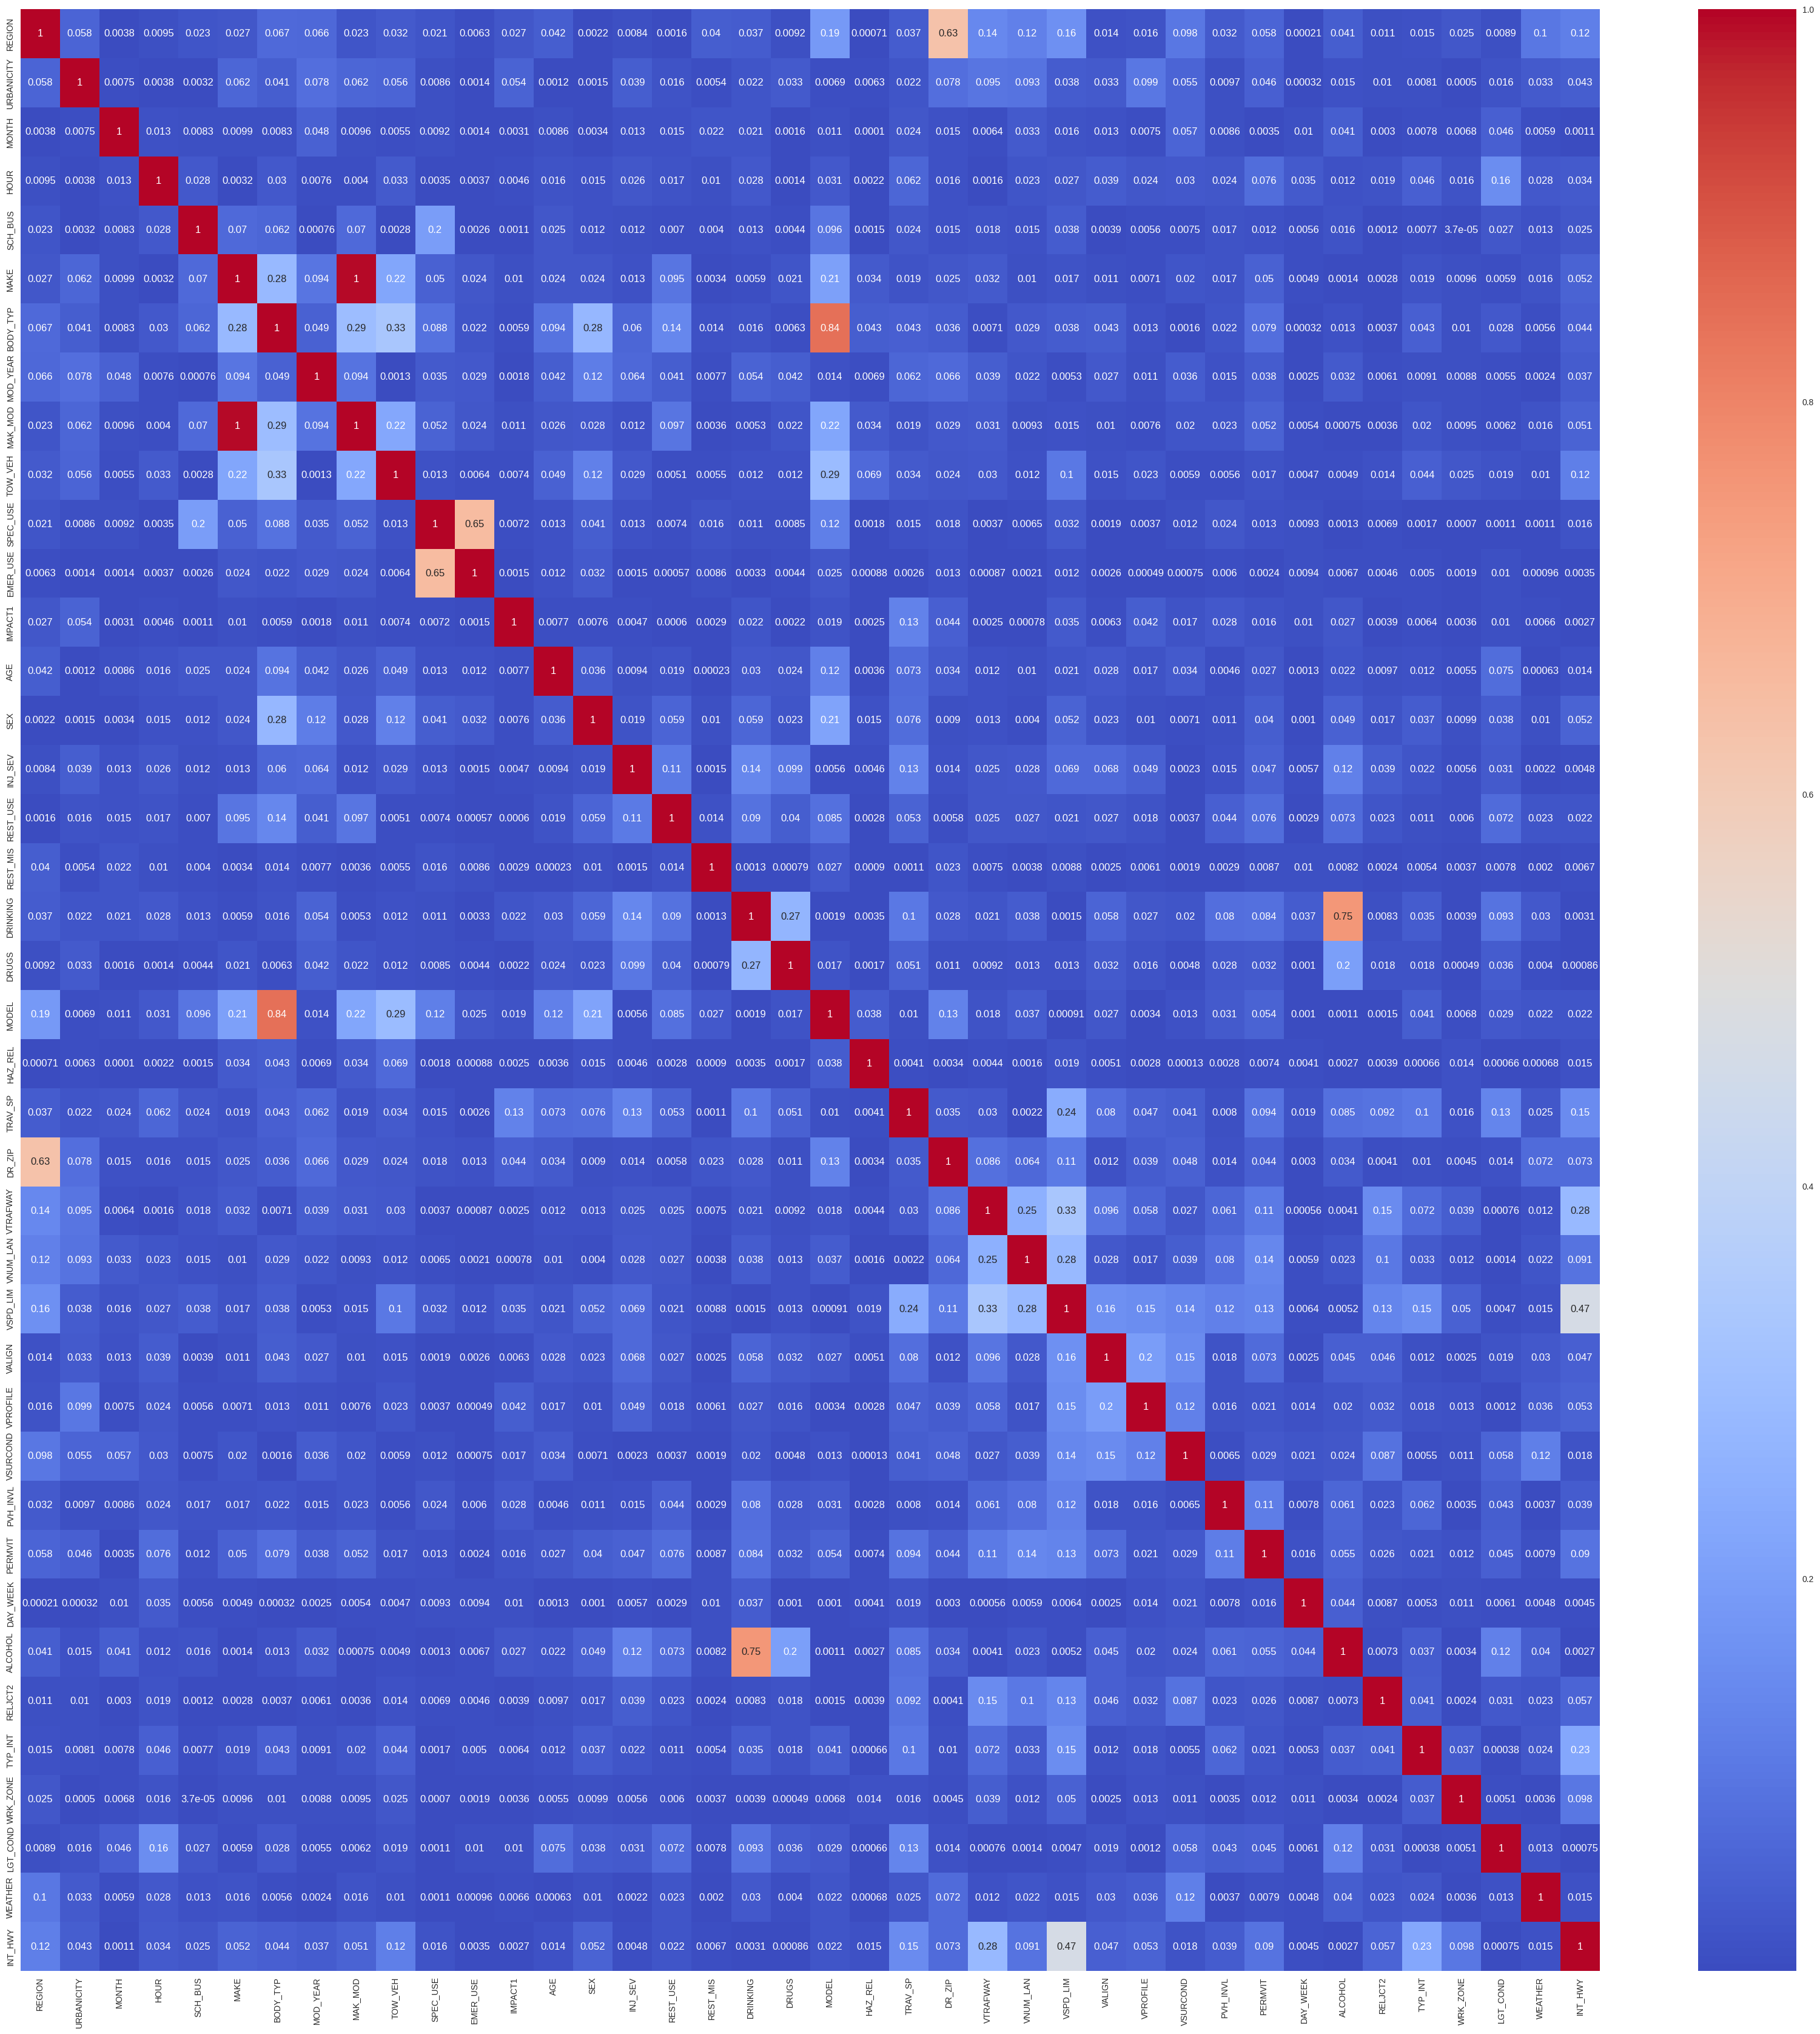

In [ ]:
plt.figure(figsize=(42,42))
sns.heatmap(full_knn.corr().abs(), annot = True, cmap = 'coolwarm')
plt.show()

  We will remove `DR_ZIP`, `MODEL`, `EMER_USE`, `ALCOHOL`, `MAK_MOD`, `PERMVIT` because they have big correlation with other featurs

In [ ]:
full_data_new = full_knn.drop(['DR_ZIP','BODY_TYP','EMER_USE','ALCOHOL','MAK_MOD'], axis = 1)

We also choose to drop the following features:

`IMPACT1`,`MAKE`,`MODEL`

because those columns contribute to the data being biased, that will lead to bad accuracy.

In [ ]:
full_data_new.drop(['IMPACT1','MAKE','MODEL'], axis = 1, inplace = True)

We split the data to categorical and numeric features

In [ ]:
categorical_features = full_data_new[['REGION','URBANICITY', 'SCH_BUS','TOW_VEH','SPEC_USE','SEX','REST_USE','DAY_WEEK','DRINKING','WEATHER','REST_MIS','DRUGS',
                                      'HAZ_REL','VTRAFWAY','VALIGN','VPROFILE','VSURCOND','RELJCT2','TYP_INT','WRK_ZONE','LGT_COND','INT_HWY']]
numeric_features = full_data_new[['MONTH','HOUR','MOD_YEAR','AGE','TRAV_SP','VSPD_LIM','VNUM_LAN','PVH_INVL','PERMVIT']]
y_new = full_data_new[['INJ_SEV']]

In [ ]:
full_data_new.columns

Index(['REGION', 'URBANICITY', 'MONTH', 'HOUR', 'SCH_BUS', 'MOD_YEAR',
       'TOW_VEH', 'SPEC_USE', 'AGE', 'SEX', 'INJ_SEV', 'REST_USE', 'REST_MIS',
       'DRINKING', 'DRUGS', 'HAZ_REL', 'TRAV_SP', 'VTRAFWAY', 'VNUM_LAN',
       'VSPD_LIM', 'VALIGN', 'VPROFILE', 'VSURCOND', 'PVH_INVL', 'PERMVIT',
       'DAY_WEEK', 'RELJCT2', 'TYP_INT', 'WRK_ZONE', 'LGT_COND', 'WEATHER',
       'INT_HWY'],
      dtype='object')

We change the type of those features as needed

In [ ]:
for col in categorical_features.columns.tolist():
  categorical_features[col] = categorical_features[col].astype(int)
  categorical_features[col] = categorical_features[col].astype('category')
full_data_new = numeric_features.join(categorical_features)
full_data_new

,MONTH,HOUR,MOD_YEAR,AGE,TRAV_SP,VSPD_LIM,VNUM_LAN,PVH_INVL,PERMVIT,REGION,...,HAZ_REL,VTRAFWAY,VALIGN,VPROFILE,VSURCOND,RELJCT2,TYP_INT,WRK_ZONE,LGT_COND,INT_HWY
0,1,8,2015,48,28,65,5,0,4,4,...,0,3,1,1,1,1,1,0,1,1
1,1,8,2010,43,28,65,5,0,4,4,...,0,3,1,1,1,1,1,0,1,1
2,1,8,2007,37,0,65,5,0,4,4,...,0,3,1,1,1,1,1,0,1,1
3,1,8,2007,67,0,65,5,0,4,4,...,0,3,1,1,1,1,1,0,1,1
4,1,14,2007,32,70,65,6,0,3,4,...,0,3,1,1,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85911,12,17,2008,27,10,25,3,0,2,4,...,0,3,1,1,1,8,1,0,3,0
85912,12,17,2014,23,10,25,3,0,2,4,...,0,3,1,1,1,8,1,0,3,0
85913,12,17,1996,66,40,25,3,0,2,4,...,0,5,1,1,1,2,2,0,3,0
85914,12,17,2017,57,10,30,2,0,2,4,...,0,1,1,1,1,2,2,0,3,0


## Split Train-Test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(full_data_new, y_new, random_state=1, test_size=0.3)
X_train.shape

(60141, 31)

##Scaling Numeric Values

In [ ]:
scaler = StandardScaler().fit(X_train[numeric_features.columns]) # training the scaler model using the train set!
X_train_scaled = pd.DataFrame(scaler.transform(X_train[numeric_features.columns]), columns = numeric_features.columns, index = X_train.index) # scaling the train set
X_test_scaled = pd.DataFrame(scaler.transform(X_test[numeric_features.columns]), columns = numeric_features.columns, index = X_test.index) # scaling the train set

## One-Hot Encoding

In [ ]:
# one-hot encoding
encoded = pd.get_dummies(categorical_features, drop_first=True)
# append the encoded columns
X_train_encoded = encoded.loc[X_train.index,]
X_test_encoded = encoded.loc[X_test.index,]

In [ ]:
X_train_scaled_encoded = X_train_scaled.join(X_train_encoded)
X_test_scaled_encoded = X_test_scaled.join(X_test_encoded)

## Over Sampling
using SMOTE because our data is imbalanced

In [ ]:
from imblearn import over_sampling as os
oversample = os.SMOTE(k_neighbors=3)
X_train_smote, y_train_smote = oversample.fit_resample(X_train_scaled_encoded, y_train)

In [ ]:
display(pd.Series(y_train_smote.value_counts()))

INJ_SEV
0          56685
1          56685
dtype: int64

Correlation of the numeric features before and after over-sampling

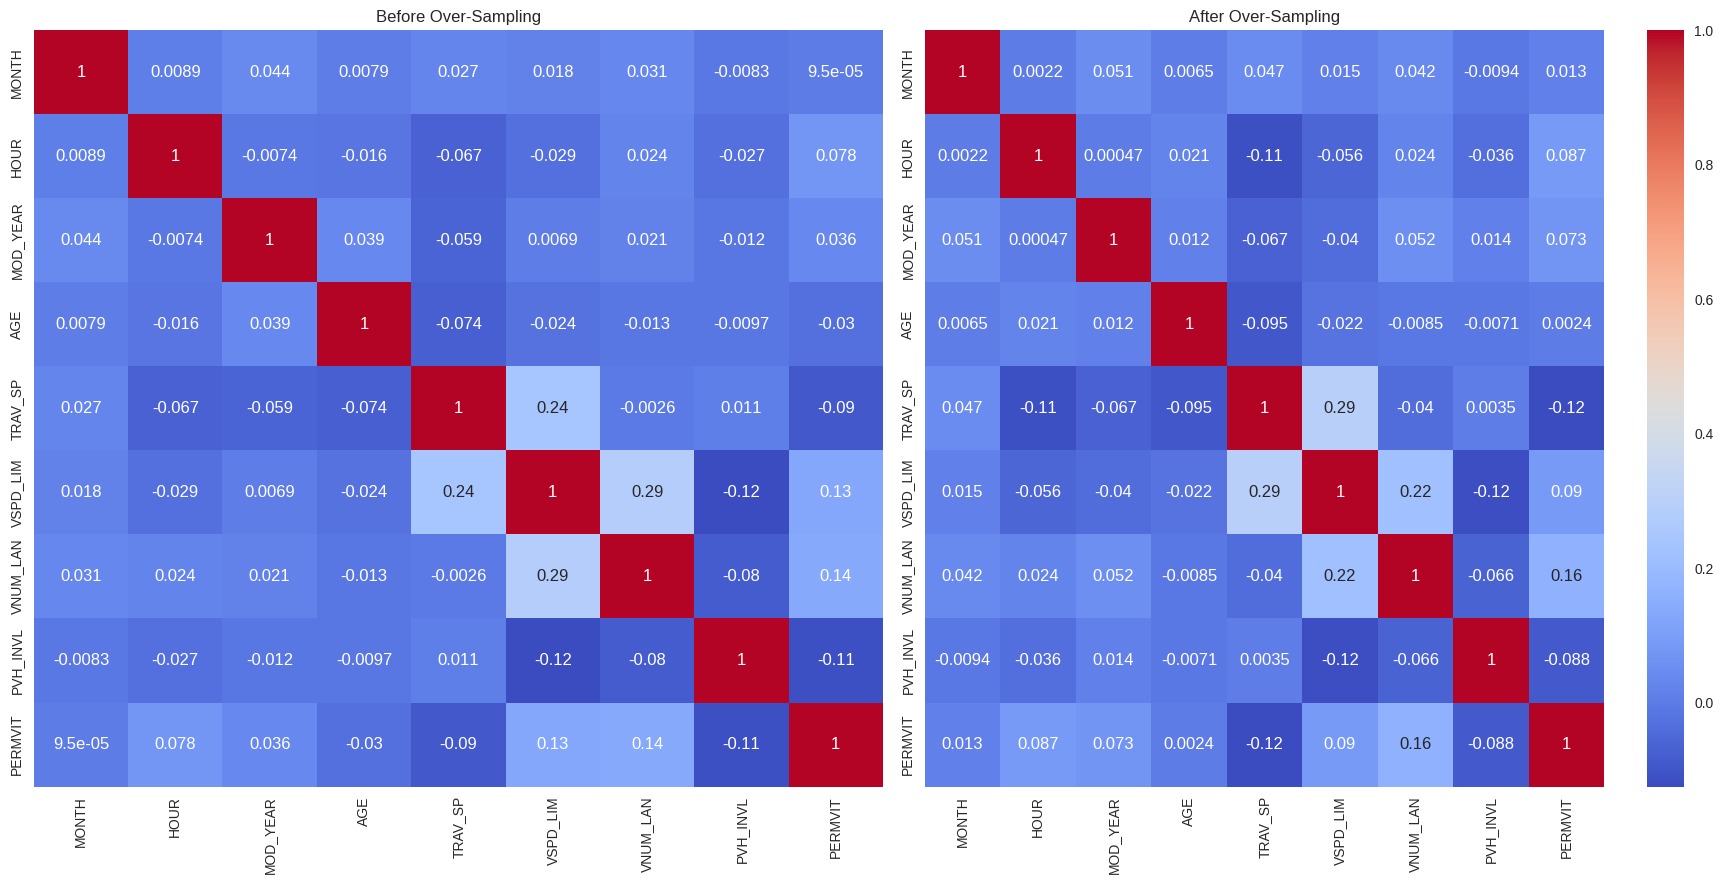

In [ ]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(18, 9))

# Plot the first correlation heatmap
sns.heatmap(X_train_scaled_encoded[numeric_features.columns].corr(), annot = True, cmap = 'coolwarm', ax = axes[0], cbar = False)
axes[0].set_title('Before Over-Sampling')

# Plot the second correlation heatmap
sns.heatmap(X_train_smote[numeric_features.columns].corr(), annot = True, cmap = 'coolwarm', ax = axes[1])
axes[1].set_title('After Over-Sampling')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

We can see that there are no correlations between the numeric features.

## Feature selection with Lasso

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=5, random_state=1)  # LassoCV automatically performs cross-validation for optimal alpha selection
lasso.fit(X_train_smote, y_train_smote)

# Select the features with non-zero coefficients from Lasso
selected_features = lasso.coef_ != 0
X_train_selected = X_train_smote.loc[:,selected_features]
X_test_selected = X_test_scaled_encoded.loc[:,selected_features]

## Feasability of the data

Correlation between the featues and the lable

<Axes: >

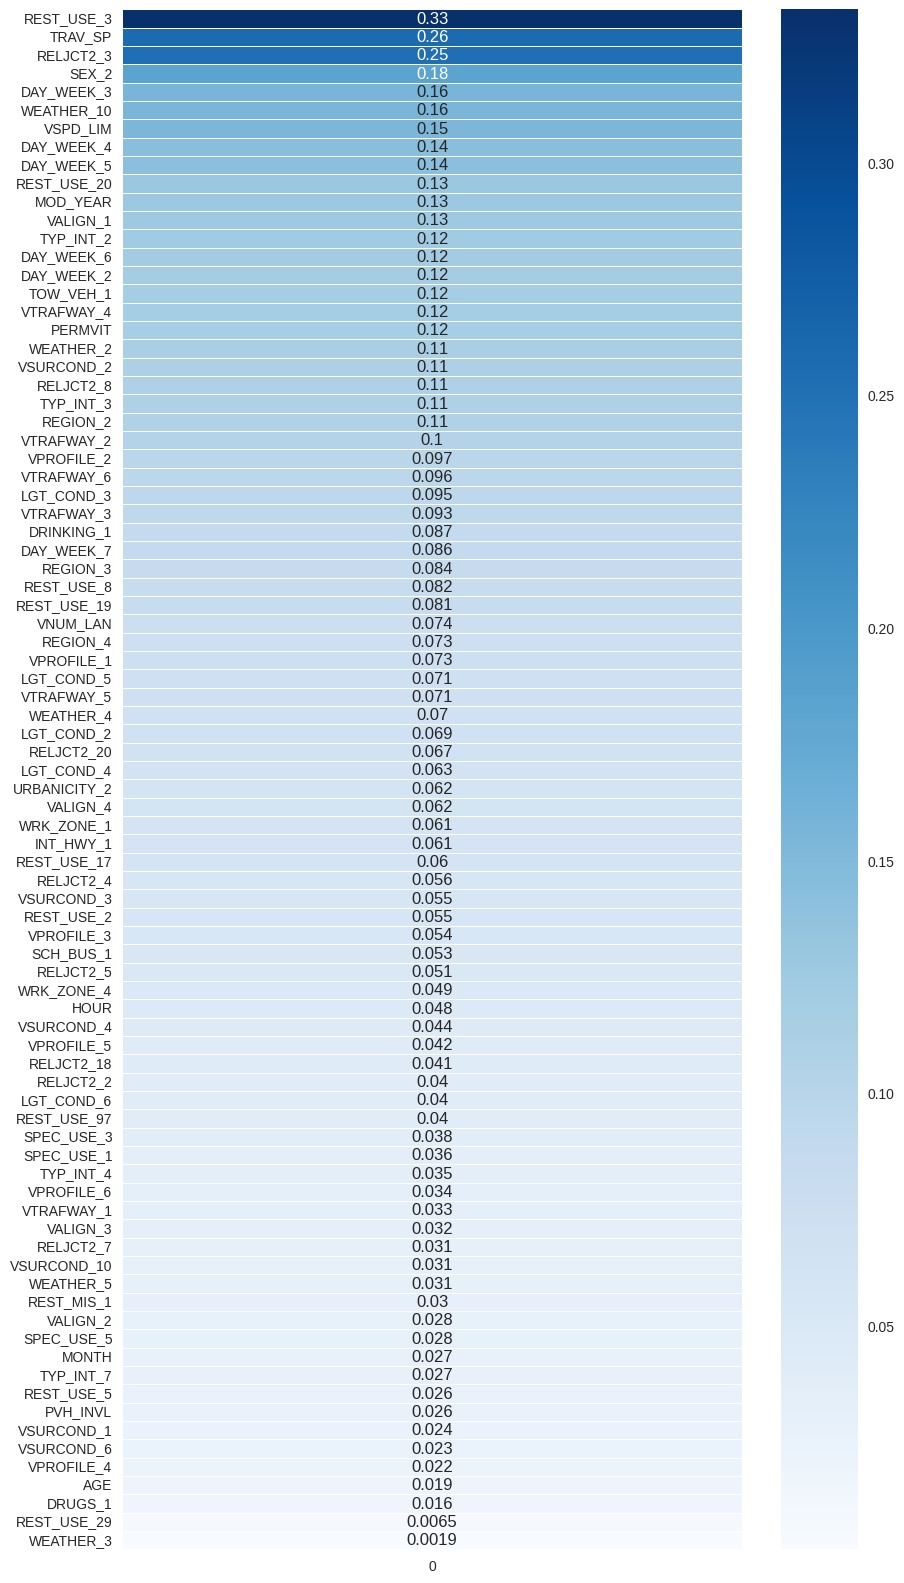

In [ ]:
test = X_train_selected.join(y_train_smote)
fig, ax = plt.subplots(figsize=(10,20))
sns.heatmap(pd.DataFrame(test.iloc[:, :-1].corrwith(test['INJ_SEV']).abs().sort_values(ascending = False)), annot = True, cmap = 'Blues', linewidths=.5, ax=ax)

## Outliers Detection

We will fit logisitic regression model (using GLM):

In [ ]:
import statsmodels.api as sm
from scipy import stats
from matplotlib import pyplot as plt
X_train_selected_c = sm.add_constant(X_train_selected, prepend=False)
glm_binom = sm.GLM(y_train_smote, X_train_selected_c, family=sm.families.Binomial())
res = glm_binom.fit()
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                INJ_SEV   No. Observations:               113369
Model:                            GLM   Df Residuals:                   113284
Model Family:                Binomial   Df Model:                           84
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34224.
Date:                Sat, 17 Jun 2023   Deviance:                       68448.
Time:                        07:30:35   Pearson chi2:                 2.21e+05
No. Iterations:                    24   Pseudo R-squ. (CS):             0.5428
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
MONTH           -0.1236      0.010    -11.903   

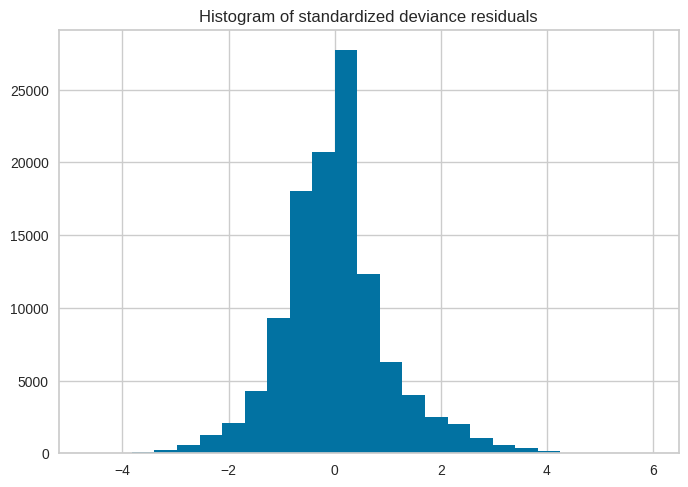

In [ ]:
from scipy import stats

fig, ax = plt.subplots()

resid = res.resid_deviance.copy()
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=25)
ax.set_title('Histogram of standardized deviance residuals');

We can see that our residuals distribution is normal with $\mu =0$

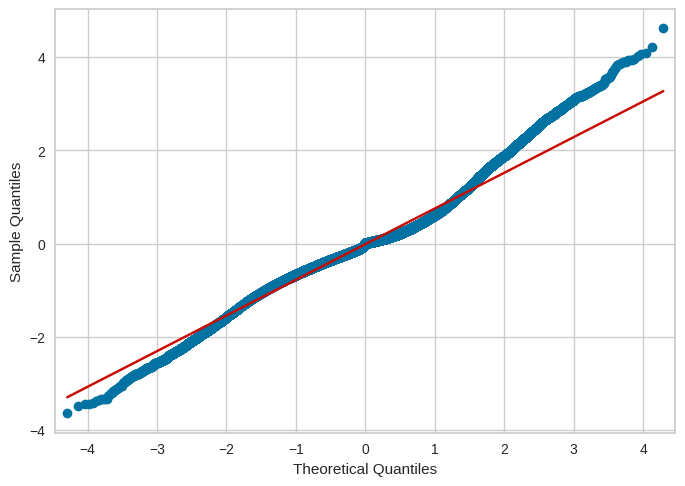

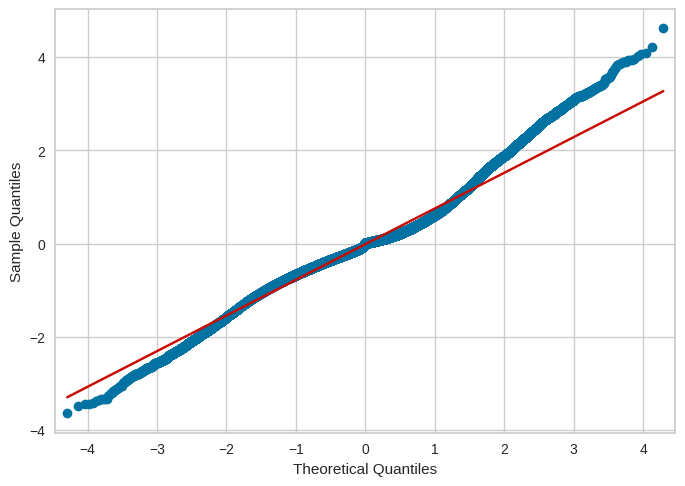

In [ ]:
from statsmodels import graphics
graphics.gofplots.qqplot(resid, line='r')

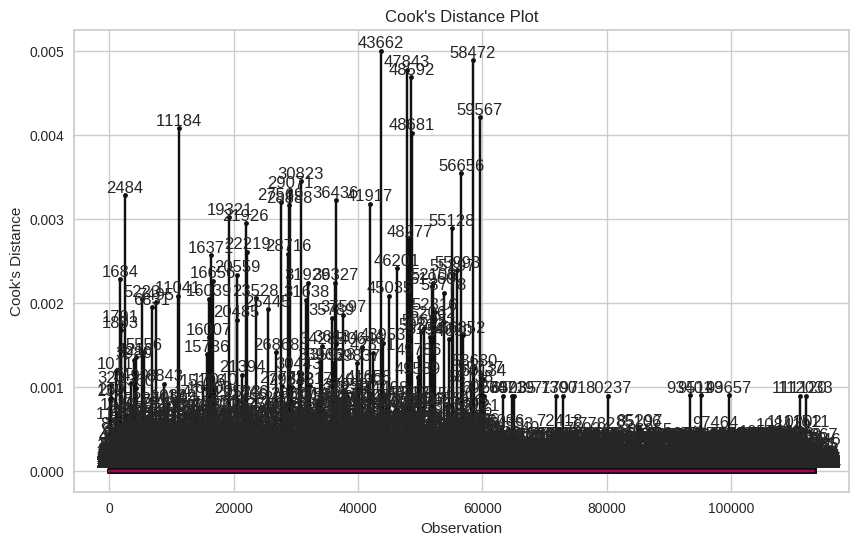

In [ ]:
# Calculate Cook's distance
influence = res.get_influence()
cooks_distance = influence.cooks_distance[0]

# Plot Cook's distance
plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_distance)), cooks_distance, markerfmt='.', linefmt='k-')

# Add annotations with observation numbers
for i, cook_dist in enumerate(cooks_distance):
    plt.text(i, cook_dist, str(i), ha='center', va='bottom')

plt.xlabel('Observation')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance Plot")
plt.show()

Removing the outlier

In [ ]:
X_train_selected.drop(2903, inplace = True)
y_train_smote.drop(2903, inplace = True)

Save the data after all the pre-processing

In [ ]:
X_train_selected.to_csv("X_Train.csv")
y_train_smote.to_csv("y_Train.csv")
X_test_selected.to_csv("X_Test.csv")
y_test.to_csv("y_Test.csv")
# X_trained = X_train_selected.copy()
# y_trained = y_train_smote.copy()
# X_tested = X_test_selected.copy()
# y_tested = y_test.copy()

# **4. Model Training**
<a class="anchor" id="section4"></a>

In [ ]:
X_trained = pd.read_csv("X_Train.csv").drop('Unnamed: 0', axis = 1)
y_trained = pd.read_csv("y_Train.csv").drop('Unnamed: 0', axis = 1)
X_tested = pd.read_csv("X_Test.csv").drop('Unnamed: 0', axis = 1)
y_tested = pd.read_csv("y_Test.csv").drop('Unnamed: 0', axis = 1)

### Logistic Regression with `L1` penalty ("Lasso") Training

First, we will start with logistic model regression classifier with `Lasso` regularization.

In [ ]:
# define model
log_reg = LogisticRegression(random_state=1, solver = 'saga', max_iter = 1000)  # max_iter = 1000 - for improving convergence
                                                                                # For logistic regression with regularization one must choose 'saga' solver

parameters_grid = {
    'penalty':['l1'],               # L1 penalty = Lasso
    'C': np.exp(np.arange(-1,2,1))  # small C values means stronger regularization and the opposite
}

# define grid search and fit the train data
l1_GSCV = GridSearchCV(log_reg, param_grid = parameters_grid, cv=5, n_jobs=-1, scoring='accuracy').fit(X_trained, y_trained)

### K-Nearest Neighbors Training

Next, we will train KNN classifier

In [ ]:
# define model
knn = KNeighborsClassifier()

# define parameter grid
parameters_grid = {
    'n_neighbors': np.arange(15,25,2)
    }

# define grid search and fit the train data
#knn_time = time.time()
knn_GSCV = GridSearchCV(estimator=knn, param_grid=parameters_grid, cv = 5, n_jobs=-1).fit(X_trained, y_trained)
#knn_time = time.time() - knn_time

### Classification Trees

In [ ]:
X_train_tree = full_data_new[full_data_new.index.isin(X_train.index)]
X_test_tree = full_data_new[full_data_new.index.isin(X_test.index)]

In [ ]:
C_tree = tree.DecisionTreeClassifier(random_state=1)
parameters = {'max_depth': range(7,11),
              'min_samples_split': range(5,11),
              'min_samples_leaf': range(5,11),
              'max_features': range(5, 14)}

#start = time()
classification_tree_cv = RandomizedSearchCV(C_tree, parameters, cv=10, n_iter=2000, n_jobs=-1, verbose=3).fit(X_train_tree, y_train) # Randomized search due to high number of combinations
##stop = time()

#print(f'Classification Tree running time = {round((stop-start)/60,3)} in minutes')

NameError: ignored

In [ ]:
classification_tree_cv.best_params_
print(f'Train Accuracy = {round(classification_tree_cv.best_score_,3)}')
print(f'Test Accuracy = {round(classification_tree_cv.score(X_test_tree, y_test),3)}')
#pd.crosstab(classification_tree_cv.best_estimator_.predict(X_test_tree), y_test, margins=True)

In [ ]:
plt.figure(figsize=(50,30))
tree.plot_tree(classification_tree_cv.best_estimator_.fit(X_train_tree, y_train), fontsize=15, filled=True, feature_names=X_train_tree.columns,
               impurity=False, node_ids=True, rounded=True)
plt.show()

### Random Forest Training

Finally, we will train Random Forest classifier

In [ ]:
# define model
rf = RandomForestClassifier(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'max_depth': np.arange(4,9,1),
    'min_samples_split': np.arange(500,800,100),
    'min_samples_leaf': np.arange(500,800,100),
    'n_estimators': np.arange(50,75,5)
}

# define grid search and fit the train data
#rf_time = time.time()
rf_GSCV = GridSearchCV(estimator=rf, param_grid=parameters_grid, cv=5, n_jobs=-1).fit(X_trained, y_trained)
#rf_time = time.time() - rf_time

# **5. Predictions and Summarized Results**
<a class="anchor" id="section5"></a>

Define `print results` that prints the confusion matrix, returns the best parameters, the confusion metrics and the list of predicted products for each user.

In [ ]:
#define function to print the Accuray, Sensitivity and Specificity
def print_results(grid_search, X, y):
  # define function that returns the accuracy, sensitivity and specificity
  def get_metrics(y_test, y_pred):
    actual_pos = y_test == 1
    actual_neg = y_test == 0

    # get confusion matrix
    mat = metrics.confusion_matrix(y_test, y_pred)
    true_neg, false_pos, false_neg, true_pos = mat.ravel()

    # calculate accuracy, sensitivity and specificity
    accuracy = round(accuracy_score(y_test, y_pred), 5)
    sensitivity = round(true_pos / np.sum(actual_pos), 5)
    specificity = round(true_neg / np.sum(actual_neg), 5)

    return accuracy, sensitivity, specificity

  # define best parameters
  best_params = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['Selected Value']).T
  # predict using the best estimator
  y_pred = grid_search.predict(X)

  # calculate confusion metrics
  accuracy, sensitivity, specificity = get_metrics(y, y_pred)

  # Generate the confusion matrix
  cm = confusion_matrix(y, y_pred)

  # Create the ConfusionMatrixDisplay object
  cmd = ConfusionMatrixDisplay(cm)

  # Plot the confusion matrix
  cmd.plot(cmap = 'YlOrRd')
  plt.grid(False)
  plt.show()

  # return metrics
  df = pd.DataFrame([accuracy, sensitivity[0], specificity[0]]).T

  #return print(sensitivity[0])
  return best_params, df.rename(index={0: type(grid_search.best_estimator_).__name__+' Classifier'}, columns={0: 'Accuracy', 1: 'Sensitivity', 2: 'Specificity'})

### Logistic Regression Results

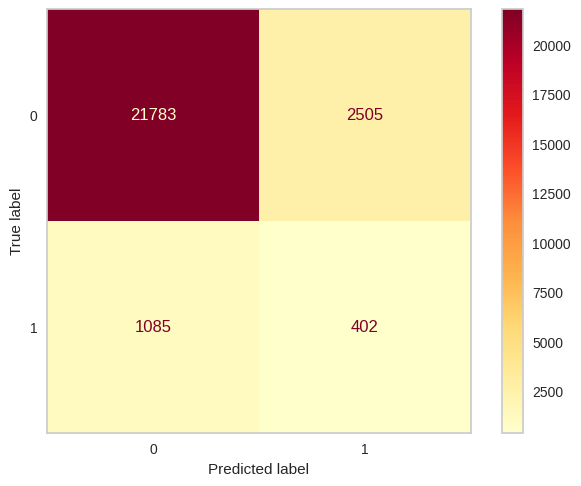

,C,penalty
Selected Value,2.718282,l1


,Accuracy,Sensitivity,Specificity
LogisticRegression Classifier,0.86072,0.27034,0.89686


In [ ]:
lr_best_params, lr_accuracy_df = print_results(l1_GSCV, X_tested, y_tested)
display(lr_best_params)
display(lr_accuracy_df)

### KNN Results

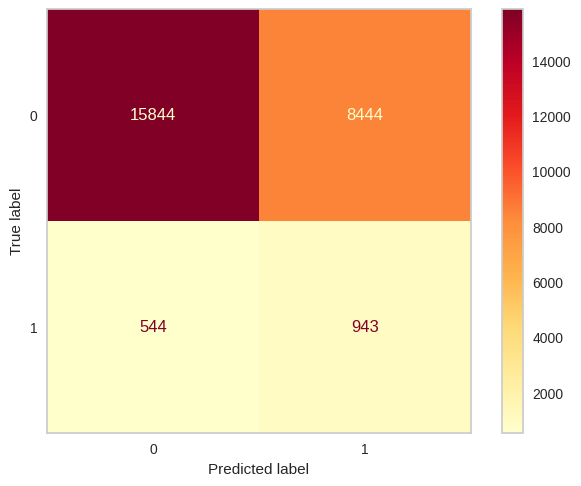

,n_neighbors
Selected Value,15


,Accuracy,Sensitivity,Specificity
KNeighborsClassifier Classifier,0.65129,0.63416,0.65234


In [ ]:
knn_best_params, knn_accuracy_df = print_results(knn_GSCV, X_tested, y_tested)
display(knn_best_params)
display(knn_accuracy_df)

### Random Forest Results

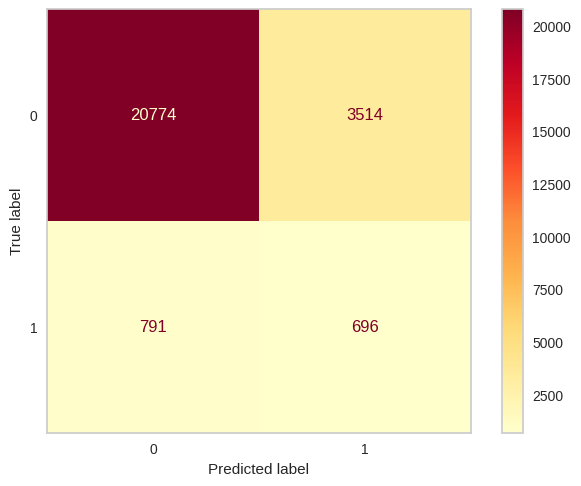

,max_depth,min_samples_leaf,min_samples_split,n_estimators
Selected Value,8,600,500,70


,Accuracy,Sensitivity,Specificity
RandomForestClassifier Classifier,0.83298,0.46806,0.85532


In [ ]:
rf_best_params, rf_accuracy_df = print_results(rf_GSCV, X_tested, y_tested)
display(rf_best_params)
display(rf_accuracy_df)

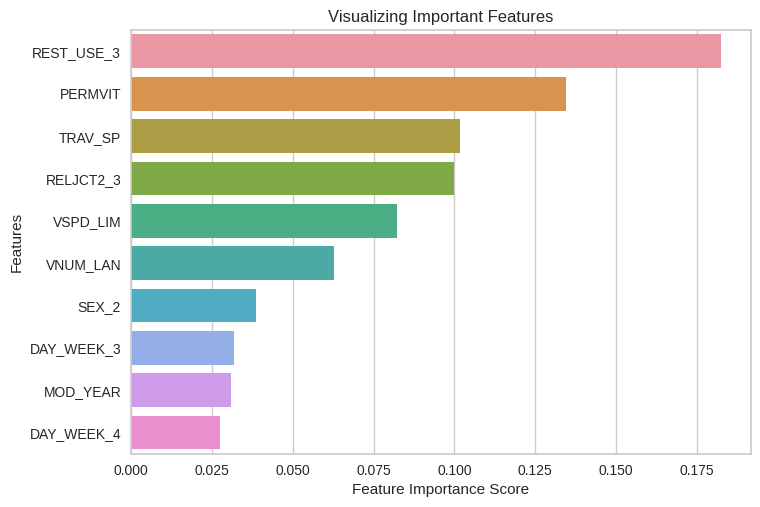

In [ ]:
feature_imp = pd.Series(rf_GSCV.best_estimator_.feature_importances_,index=X_tested.columns).sort_values(ascending=False)

# Creating a bar plot, displaying only the top k features
k=10
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

### ROC Comparison

In [ ]:
def ROC_comparison(Models, Models_names, x_test, y_test, subtitle = 'Train set'):
    def plot_roc(Model, x_test, y_test):
      fpr, tpr, thresholds  = roc_curve(y_test, Model.predict_proba(x_test)[:,1])
      plt.plot(fpr, tpr)
      return round(auc(fpr, tpr),5)

    auc_res = 0
    plt.figure(figsize=(6, 6))
    for i,Model in enumerate(Models):
      #if(Models_names[i] == 'Random Forest'):
        #auc_res = plot_roc(Model, x_test_rf, y_test)
      #else:
        auc_res = plot_roc(Model, x_test, y_test)

        Models_names[i] = Models_names[i]+" = "+(str(auc_res))

    plt.plot([0,1],[0,1], '--', color='black')
    plt.legend(labels = Models_names, title = 'AUC')
    plt.grid()
    plt.title('ROC curve \n'+subtitle)
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.show()

#### Train

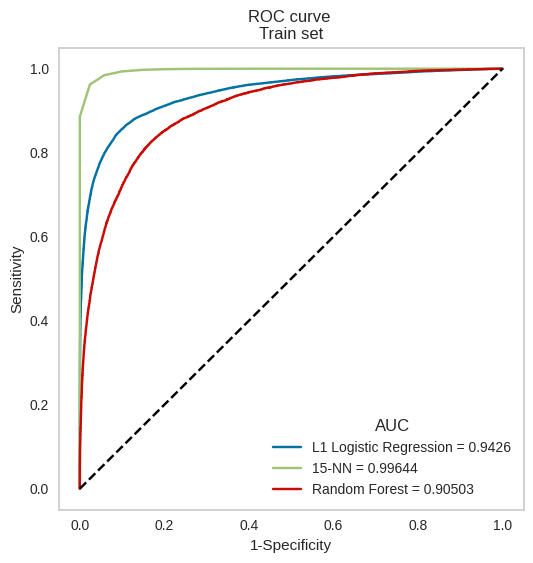

In [ ]:
Models = [l1_GSCV, knn_GSCV, rf_GSCV]
Labels = ['L1 Logistic Regression', str(knn_GSCV.best_params_['n_neighbors'])+'-NN','Random Forest']
ROC_comparison(Models, Labels, X_trained, y_trained, 'Train set')

#### Test

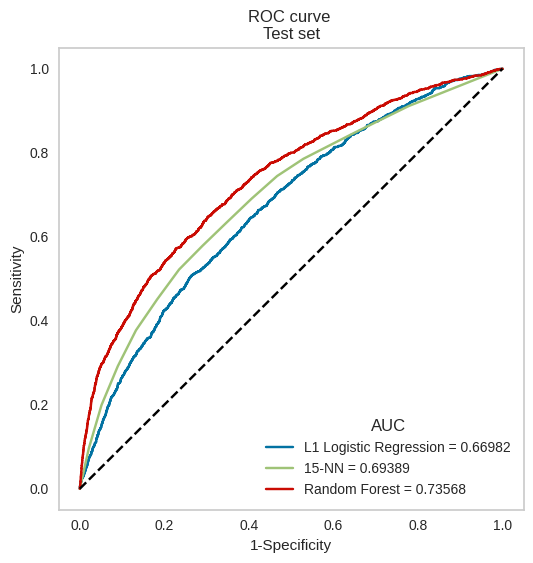

In [ ]:
Models = [l1_GSCV, knn_GSCV, rf_GSCV]
Labels = ['L1 Logistic Regression', str(knn_GSCV.best_params_['n_neighbors'])+'-NN','Random Forest']
ROC_comparison(Models, Labels, X_tested, y_tested, 'Test set')

# **Notes**
<a class="anchor" id="section7"></a>

PER_NO: the serial number of the person in the car (randomly selected by the reporter), so it is unrelevent.

STRATUM: 10 - other (not case 1,2,3,4,5,6,7,8,9).

STR_VEH: all columns are 0, so we can remove.

HOUR:we have 278 observation of missing values (99). We can see that less accidents occor at night and we don't have the data to show the accidents in relation to the number of driving vehicles at this time. (and we have multiple rows because it's persons dataframe and not the accidents dataframe)

MINUTE: The reporter round the minutes and it's unrelevent (so we can remove it)

MAN_COLL: 531 observations unknown to impute (98)

SCH_BUS: really small observation that are school bus, maybe remove this column, this indication doesn't affect the results because we can see buses in the model of the vheicle

MAKE: 2347 observations with unkown to impute (99) and maybe because of small samples we will combine values - unbalanced and MAK_MODEL is a bit more balanced

BODY_TYP: 1466 observation unkown to impute (98,99) and again maybe combine values

MOD_YEAR: 3094 observations to impute (9999,9998) and cobline under 2002 value

TOW_VEH:Vehicle Trailing, remove column, creates unbalanced data ????????????

SPEC_USE: same

EMER_USE: same

ROLLOVER: same

IMPACT1: impute observations (98,99) and combine by sub category

FIRE_EXP: remove ????

AGE: need to impute (999,998)

SEX: need to impute (8,9)

PER_TYP: can remove from drivers because we chose only the drivers so all observations have the same value

INJ_SEV: Label: impute (9)

SEAT_POS: remove

REST_USE: impute (99,98) maybe combine

REST_MIS: remove

AIR_BAG: impute (99,98) and combine to deployed or not deployed

EJECTION: impute (7,8,9) maybe remove because it's small

DRINKING, ALC_STATUS, ATST_TYP, ALC_RES: impute (8,9), probably high correlation (ALC_RES is the best)

DRUGS: IMPUTE (8,9) meybe remove it's small

HOSPITAL: impute (8,9) and combine to transfered or not

CASENUM, REGION, URBANICITY, STRATUM, VE_FORMS, MONTH, HOUR, MINUTE, HARM_EV, MAN_COLL, BODY_TYP, EMER_USE, FIRE_EXP, IMPACT1, MAK_MOD, MAKE, MOD_YEAR, ROLLOVER, SPEC_USE, TOW_VEH, PJ: the same columns as in Person

NUMOCCS: 99 -Unknown and we can agrigate all the observations where value bigger than 9

HIT_RUN: can remove 97% unkown and it is irrelevant

MODEL :999 impute

GVWR: can remove 97% unkown

CARGO_BT: can remove 97% unkown

HAZ_INV:Hazardous Materials Involvement,can remove 99% ????????

HAZ_REL:Release of Hazardous Material from the Cargo Compartment,  can remove 99% unkown ???????????????????? , 8-MISSING VALUE

BUS_USE: can remove irrelevant

TRAV_SP: impute 998, 999 and aggregate

ROLLOVER: 97% didn't roll over

ROLINLOC: can remove, it is irrelevant

IMPACT1: impute 98,99 and maybe aggregate only to clock points andtop or bottom

DEFORMED: impute 8,9

TOWED: imptute 8,9 high corr between

M_HARM: same as HARM_EV

VEH_ALCH: remove because we have in person the result of the alc test

MAX_VSEV: remove because we have the driver inj_sev already

NUM_INJV: same as NUM_INJ in persons

FIRE_EXP: can remove 99% unkown???????????????????????

DR_PRES: can remove 99% unkown, almost all values is "yes"

DR_ZIP: impute 99999

SPEEDREL: can remove 97% didn't speed

DR_SF1, DR_SF2, DR_SF3, DR_SF4: can remove 97% subjective data

VTRAFWAY: impute 8,9

VNUM_LAN: impute 8,9

VSPD_LIM: impute 98,99

VALIGN: impute 8,9

VPROFILE: impute 8,9

VSURCOND: impute 98,99

P_CRASH1: impute 98,99

P_CRASH2: impute 98,99

P_CRASH3: can remove? maybe combine all the P_CRASH

ACC_TYP: impute 98,99

CASENUM, REGION, URBANICITY, STRATUM : the same columns as in Person

VE_TOTAL , VE_FORMS : didn't understand the difference between them

PVH_INVL: Number of Parked/Working Vehicles, no missing values

PEDS: Number of Persons Not in Motor Vehicles, maby remove because most of the observation is 0 and it is not relevant to our analysis

PERMVIT: Number of Persons in Motor Vehicles in Transport, no missing values

PERNOTMVIT: Number of Persons Not in Motor Vehicles in Transport,  maby remove because most of the observation is 0 and it is not relevant to our analysis.

NUM_INJ: 0 No Person Injured/Property Damage Only Crash
         x Number of Known Injured
        98 No Person Involved in the Crash
        99 All Persons in Crash Are Unknown if Injured - need to impute?

MONTH: no need to impute

DAY_WEEK: no need to impute

HOUR: 99- unknown - 229 observatins

MINUTE: The reporter round the minutes and it's unrelevent (so we can remove it)

HARM_EV: same as Person

ALCOHOL: 9- unknown - need to impute

MAN_COLL: same as Person

RELJCT1: Relation to Junction- Within Interchange Area - 8- Not Reported, 9-Reported as Unknown

RELJCT2: 98-Not Reported , 99-Reported as Unknown

TYP_INT- Type of Intersection-  98-Not Reported , 99-Reported as Unknown

WRK_ZONE: unbalance data

REL_ROAD: 98-Not Reported , 99-Reported as Unknown

LGT_COND: 8-Not Reported , 9-Reported as Unknown

WEATHER1 + WEATHER2 +WEATHER: 98-Not Reported , 99-Reported as Unknown

SCH_BUS: almost all observations are 0

INT_HWY: Interstate Highwa- 9-Unknown- only 4 observations



Under Sampling:

## Assumptions
**Assumption 1**: We don't have any indication of multiple accidents on one driver, so we will assume that each accident happend from a unique driver.

**Assumption 2**: We can see that the accidents sampled are not distributed normally across all the states and their population and it causes bias in the data, we assume that it is distributed normally.

**Assumption 3**: We saw that the car make and model that correlates with tha label were Amrican companies and that is make sense because the data is from the USA and we showed that we have alot more American compenies from other, and that makes our data baise so we desided to drop this columns.